Find front direction, rotate velocity along front, calculate estimate shear and density gradient from thermal wind balance and compare to observations 

### Import Packages 

In [119]:
# for local use 
import sys
sys.path.append("/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/utilities")
from Utils import *
from ATOMIC_Utils import *
from Gradient_LeastSquares import *

In [120]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
import pandas as pd
import sys
# sys.path.append("/home/mlb15109/Research/ATOMIC/github_repos/ATOMIC_MesoscaleFront/utilities")
# from Utils import *
# from ATOMIC_Utils import *
# from Gradient_LeastSquares import *
from matplotlib.colors import LogNorm

import seawater as sw
from sklearn.metrics import pairwise_distances
from scipy import stats
from pycurrents.adcp.rdiraw import Multiread
from sklearn.metrics.pairwise import nan_euclidean_distances

### Functions

In [143]:
def Calculate_Vector_Magnitude_Angle(x,y):
    """
    """
    mag = np.sqrt(x**2 + y**2)   # magnitude 
    angle = np.arctan2(y,x)  # angle in radians 
    angle = (angle * (180/np.pi))   # angle in degrees 

    return mag, angle 

def Calculate_Front_Direction(rho_angle):
    """
    """
    front_direction = rho_angle - 90     # 90 degrees 

    return front_direction 


def front_unit_vectors(front_direction):
    """
    """
    x = np.cos((front_direction * (np.pi/180))) # create x-direction for front 
    y = np.sin((front_direction * (np.pi/180))) # create y-direction for front

    return x,y


def rotate_velocity(u,v,angle):
    """Function that rotates velocity component vectors using rotation equations
       
       Inputs: v: u velocity, v velocity, angle: angle between vectors [radians]
       Outputs: rotated v velocity vectors 
    """
    u_prime = u*np.cos(angle) - v*np.sin(angle)
    v_prime = u*np.sin(angle) + v*np.cos(angle)
    
    return u_prime,v_prime

### Load Datasets 

In [123]:
# load datasets
coefs = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/coefs.nc')
coefs_nonadcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/coefs_nonadcp.nc')
subset = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/MergedDS_FrontFinder.nc')


In [124]:
import glob

# absolute path to search all text files inside a specific folder
path_fronts = '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/90_100_Percentile_Interp05km/*.nc'
path_coefs_nonadcp = '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/90_100_Percentile_Interp05km/coefs_nonadcp/*.nc'
path_coefs = '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/90_100_Percentile_Interp05km/coefs/*.nc'





In [125]:
filelist_fronts = glob.glob(path_fronts)
filelist_coefs = glob.glob(path_coefs)
filelist_coefs_nonadcp = glob.glob(path_coefs_nonadcp)

In [127]:
len(filelist_coefs)

82

In [128]:
# sorts files in order from 1,2,3,4,.... instead of 0,1,10,11,12,...2,20,21,....
from natsort import natsorted 
filelist_fronts = natsorted(filelist_fronts)
filelist_coefs = natsorted(filelist_coefs)
filelist_coefs_nonadcp = natsorted(filelist_coefs_nonadcp)

In [129]:
dslist_subset = []
coefs_adcp = []
coefs_nonadcp = []
for i in range(len(filelist_fronts)):
    dslist_subset.append(xr.open_dataset(filelist_fronts[i]))
    coefs_adcp.append(xr.open_dataset(filelist_coefs[i]))
    coefs_nonadcp.append(xr.open_dataset(filelist_coefs_nonadcp[i]))

                     

### Thermal Wind Calculations 

In [130]:
# calculate rho magnitude & direction, front direction, and rotate velocity to be in line with front 
for i in range(len(coefs_adcp)):
    rho_mag, rho_angle = Calculate_Vector_Magnitude_Angle(x=coefs_nonadcp[i].rhox,y=coefs_nonadcp[i].rhoy)
    coefs_nonadcp[i]['rho_mag'] = rho_mag
    coefs_nonadcp[i]['rho_angle'] = rho_angle
    
    front_direction = Calculate_Front_Direction(coefs_nonadcp[i].rho_angle)
    coefs_nonadcp[i]['front_direction'] = front_direction
    
    vel_mag, vel_angle = Calculate_Vector_Magnitude_Angle(x=coefs_adcp[i].u_mean,y=coefs_adcp[i].v_mean)
    coefs_adcp[i]['vel_mag'] = vel_mag
    coefs_adcp[i]['vel_angle'] = vel_angle 
    
    # get angle between velocity and front (clockwise???)
    angle = coefs_adcp[i].vel_angle - coefs_nonadcp[i].front_direction
    # 360 minus angle to get counter clockwise direction???
    angle = 360-angle
    
    # get rotated velocity components 
    u_prime, v_prime = rotate_velocity(coefs_adcp[i].u_mean, coefs_adcp[i].v_mean, angle*(np.pi/180))
    
    # calculate magnitude of rotated velocity 
    vmag_prime = np.sqrt(u_prime**2 + v_prime**2)
    
    coefs_adcp[i]['vel_mag_prime'] = vmag_prime
    coefs_adcp[i]['u_prime'] = u_prime
    coefs_adcp[i]['v_prime'] = v_prime

    y = np.sin((coefs_nonadcp[i].front_direction * (np.pi/180))) # create y-direction for front 
    x = np.cos((coefs_nonadcp[i].front_direction * (np.pi/180))) # create x-direction for front 

    coefs_nonadcp[i]['x'] = x
    coefs_nonadcp[i]['y'] = y
    

### Plots 

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_15223/2182569692.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,6))


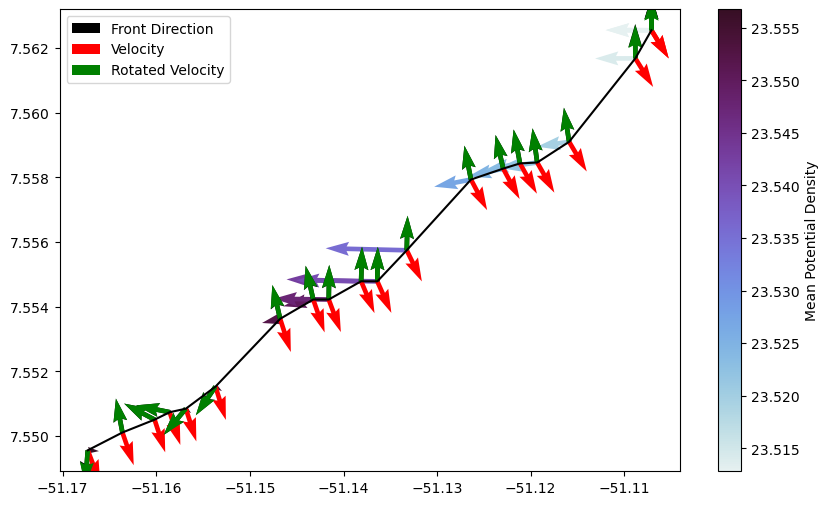

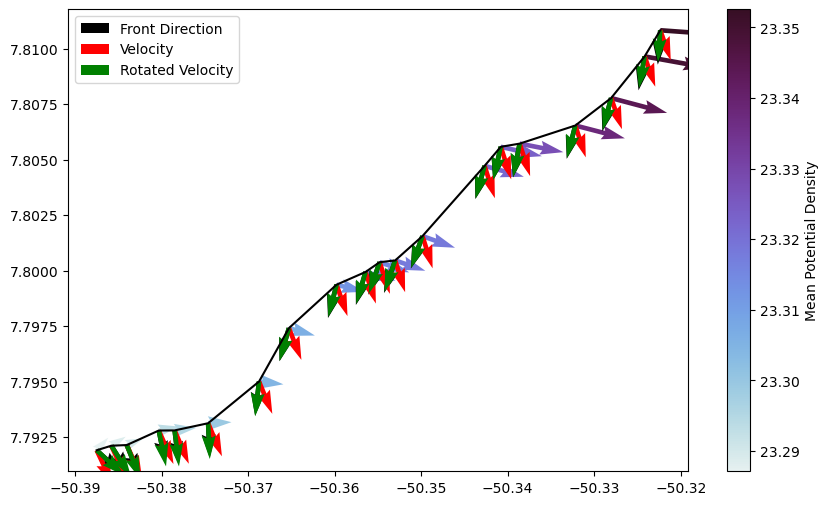

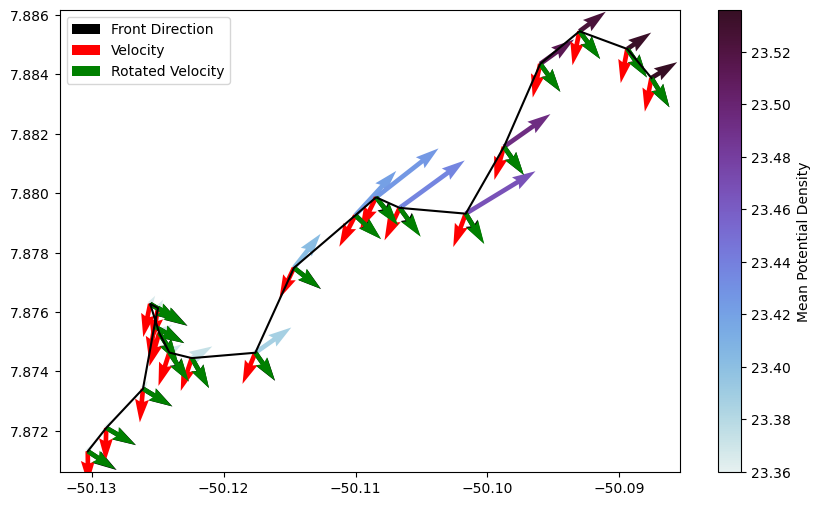

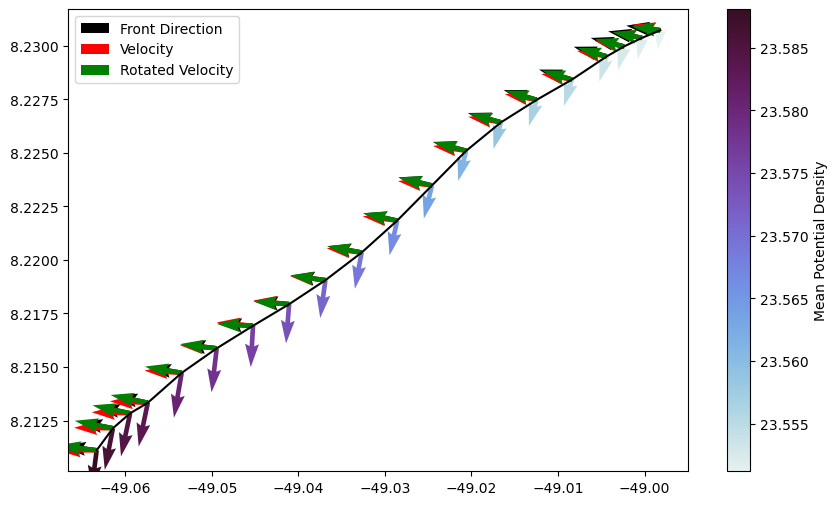

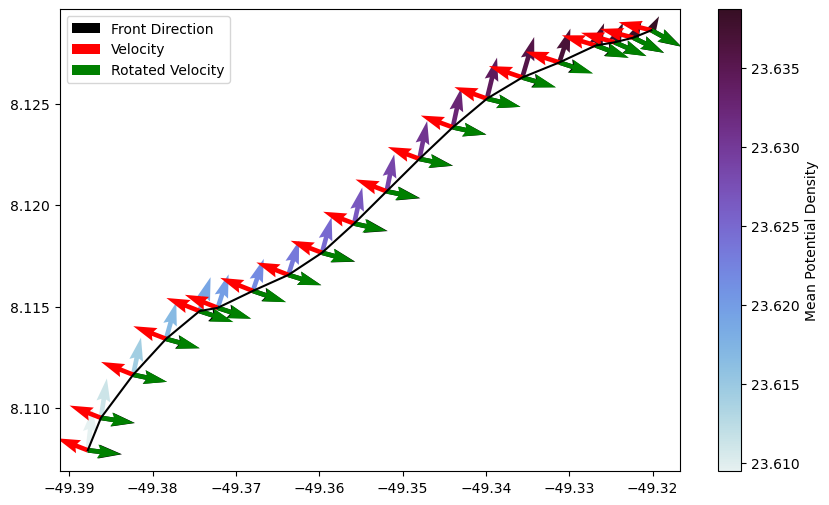

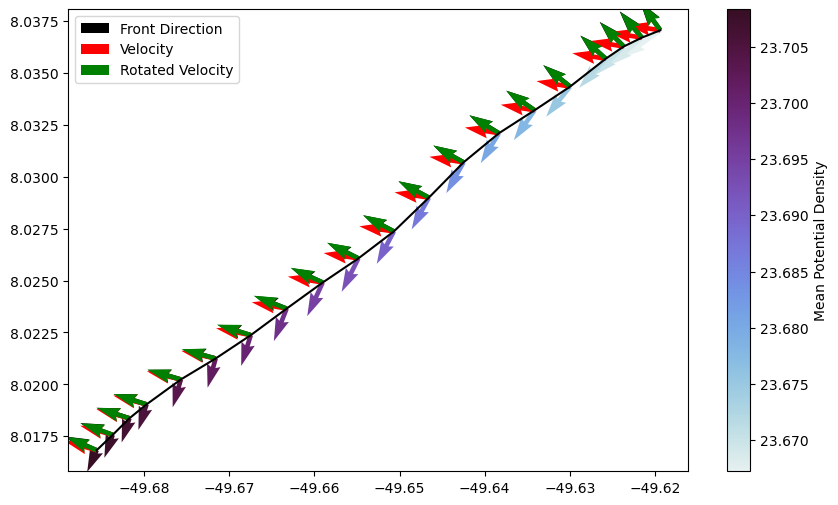

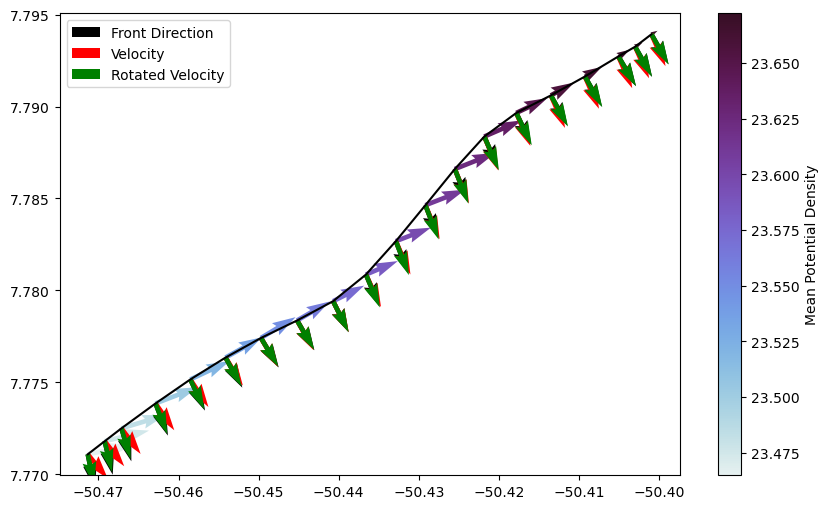

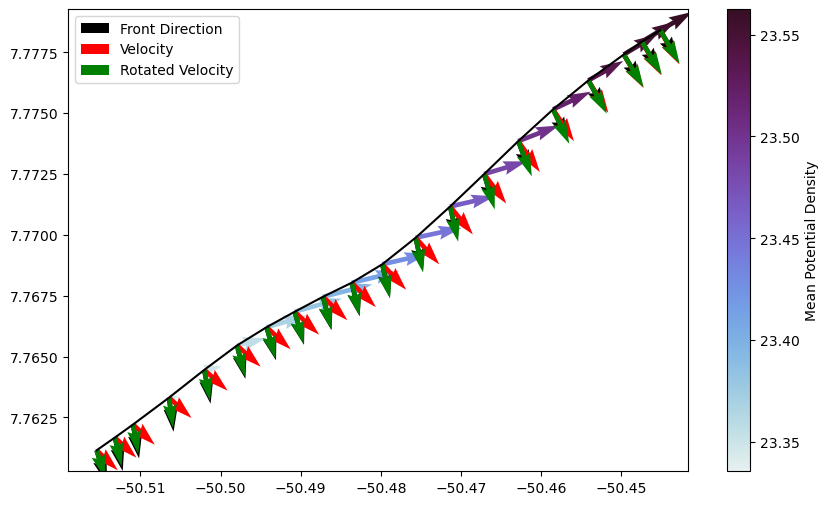

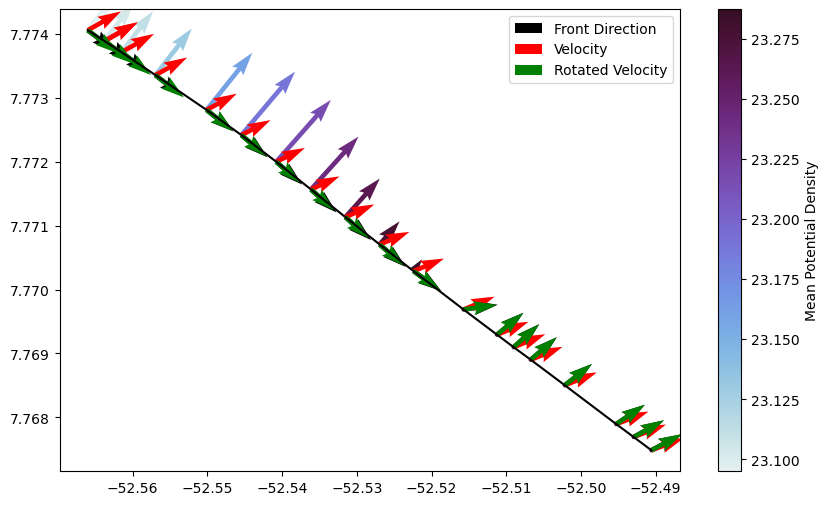

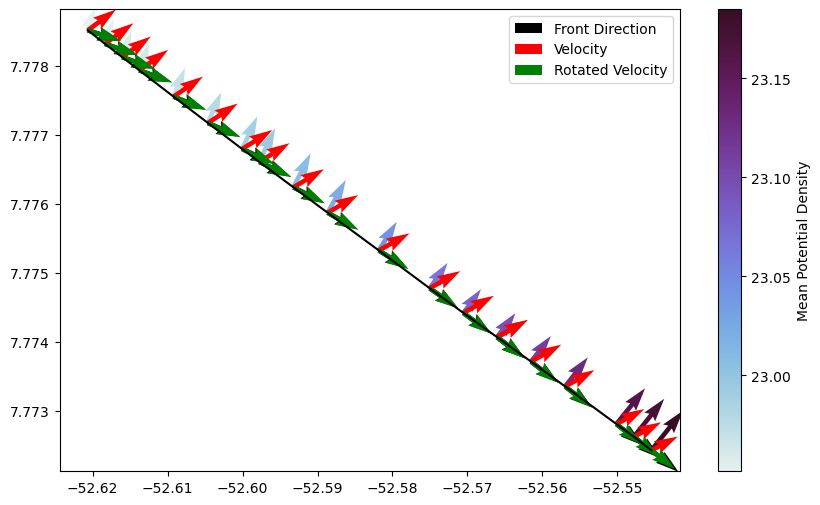

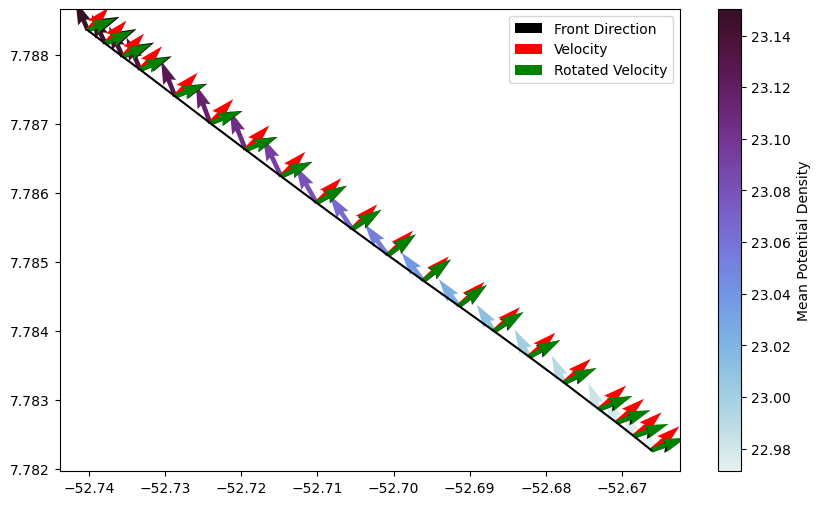

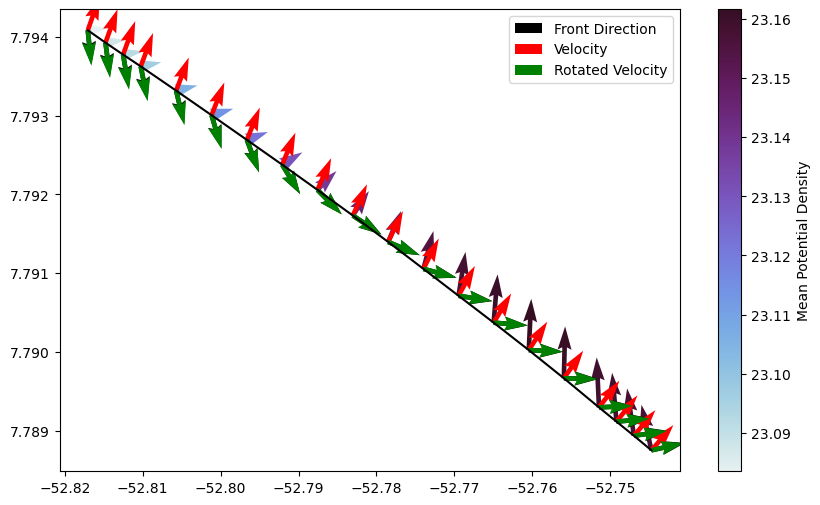

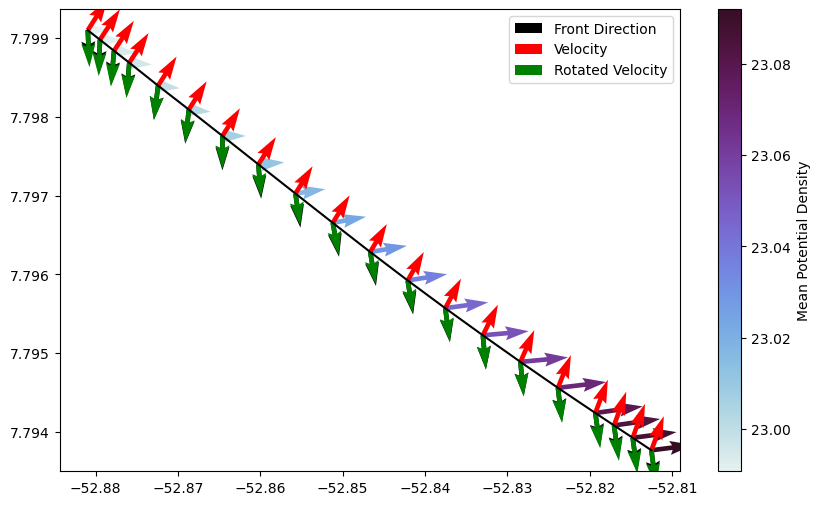

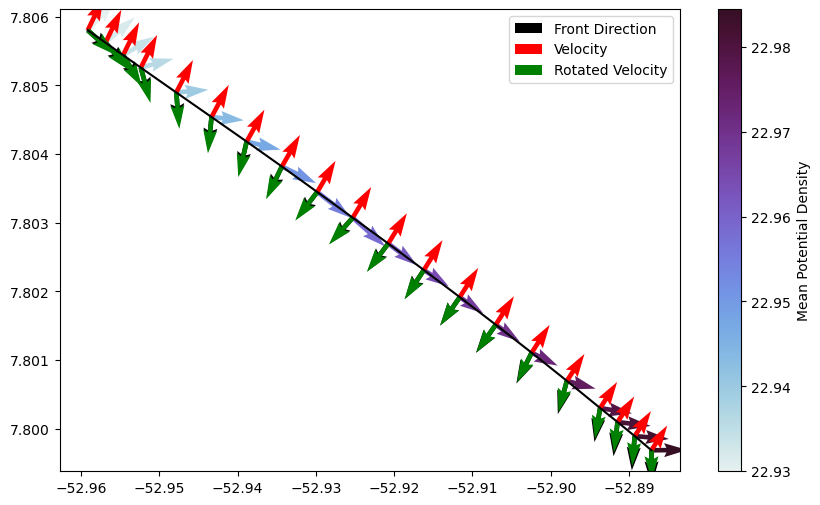

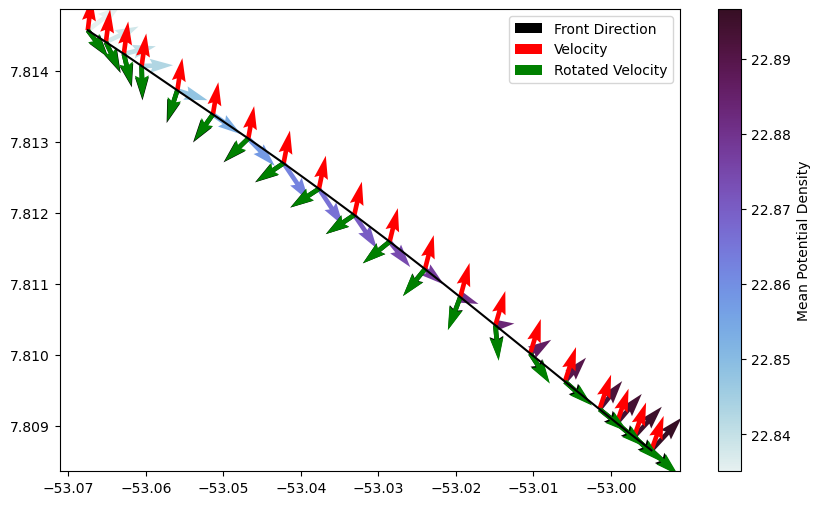

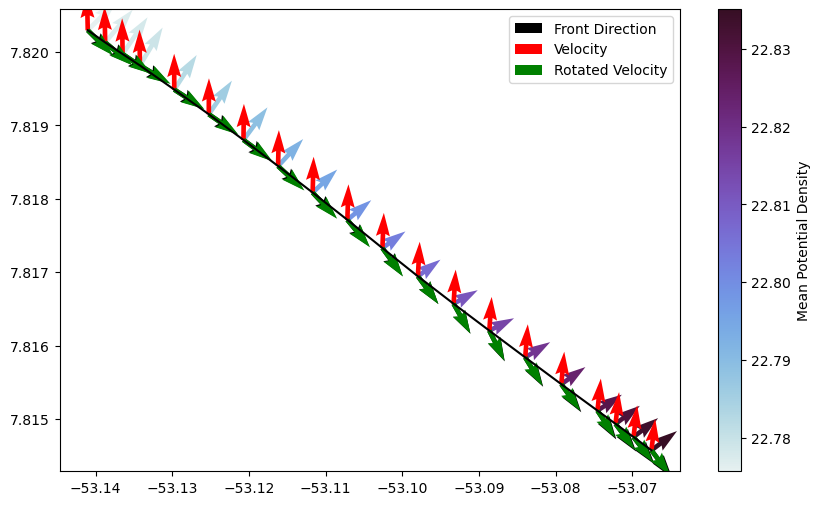

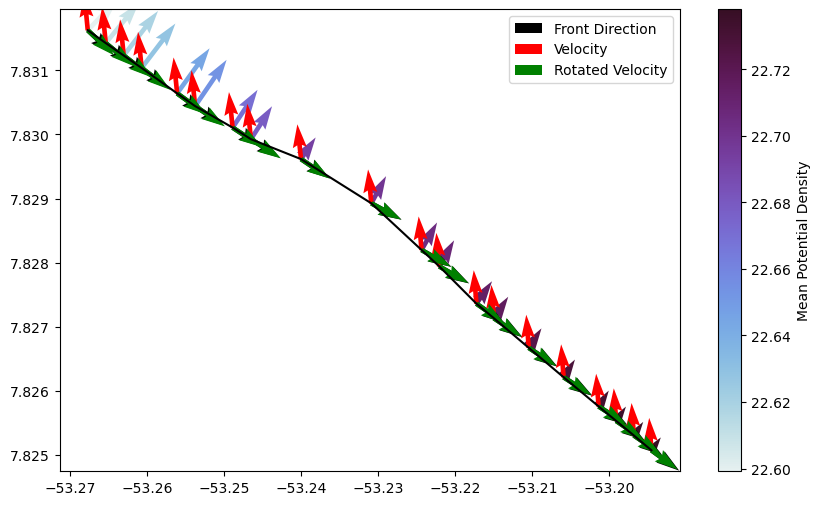

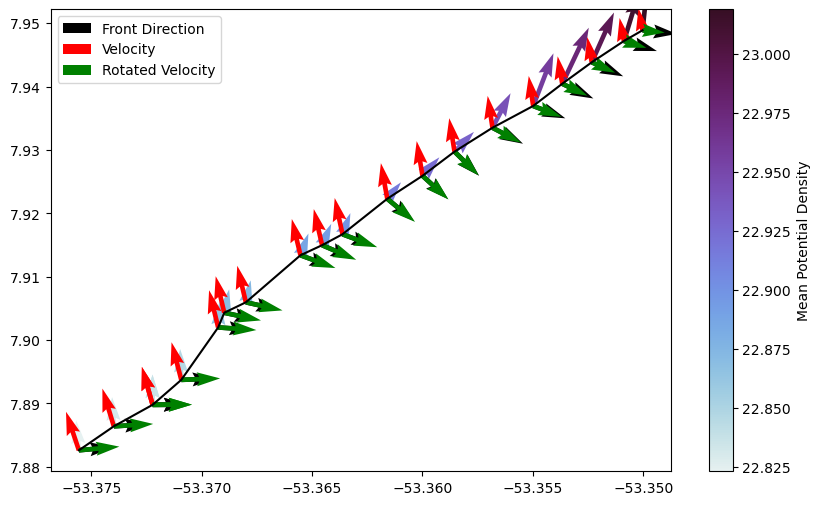

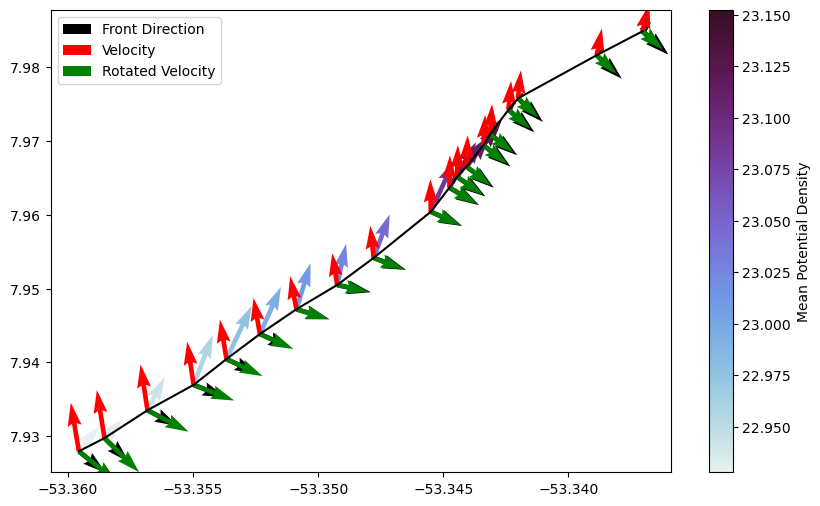

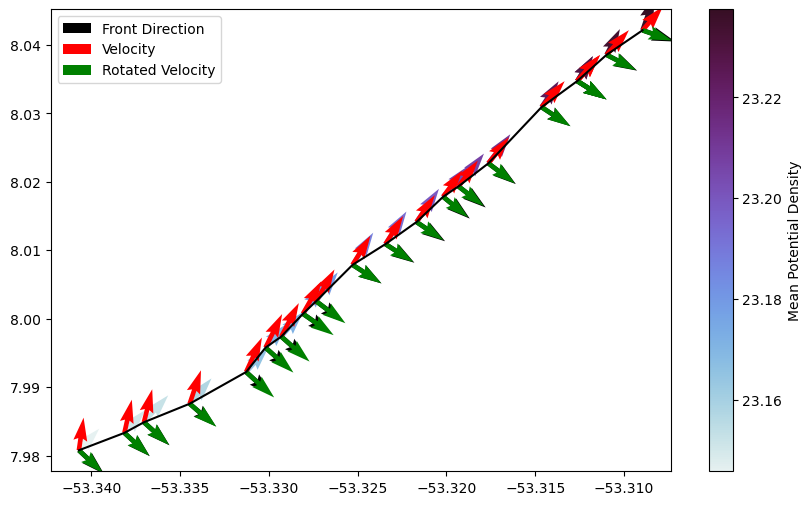

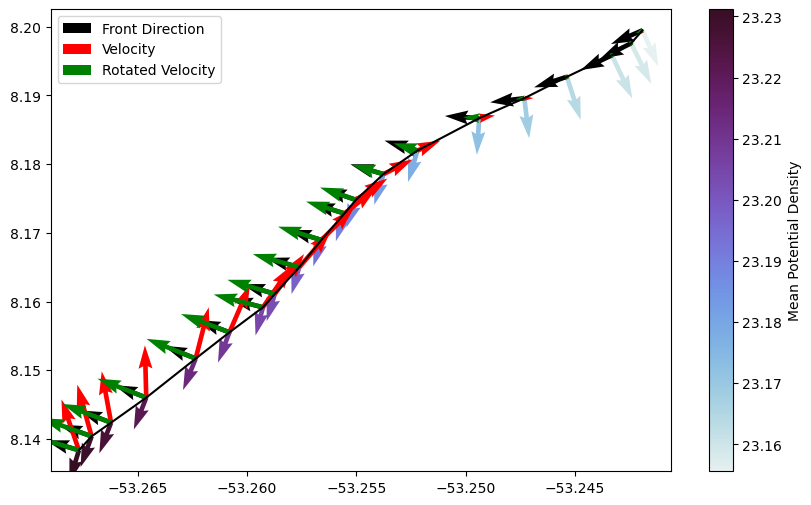

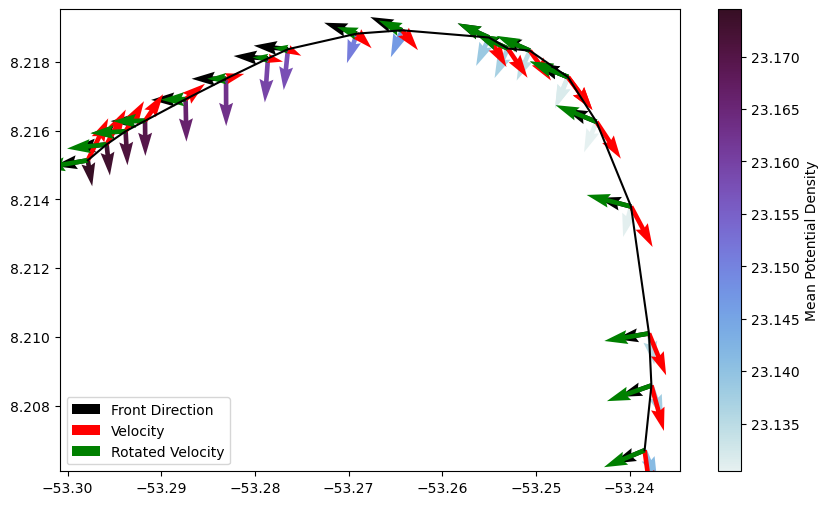

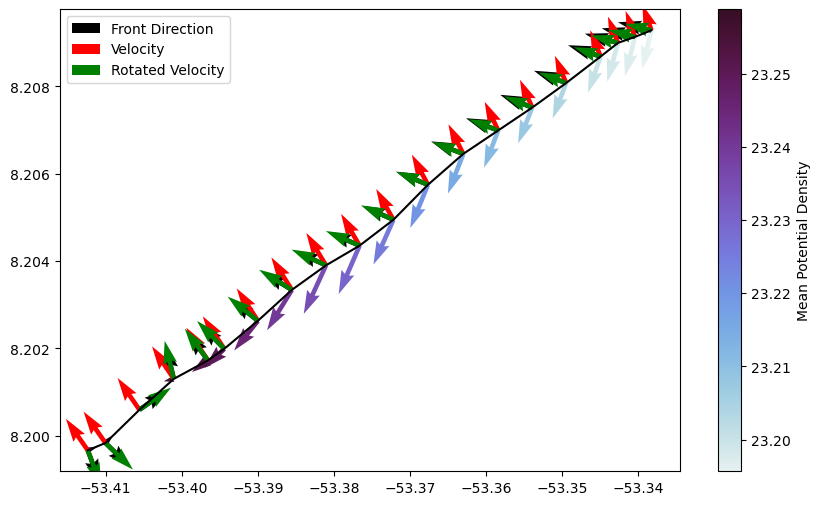

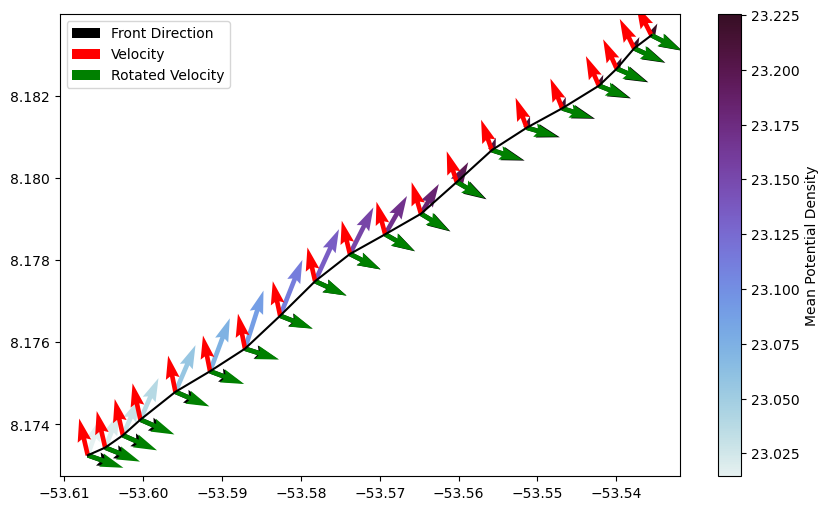

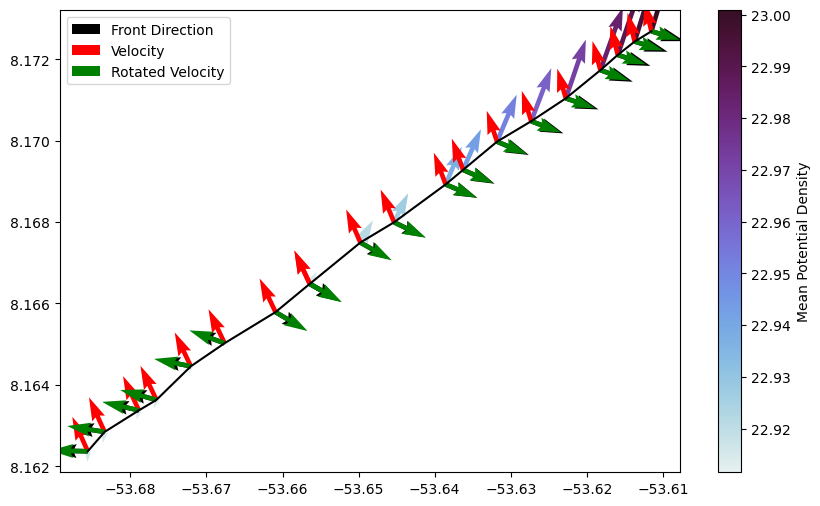

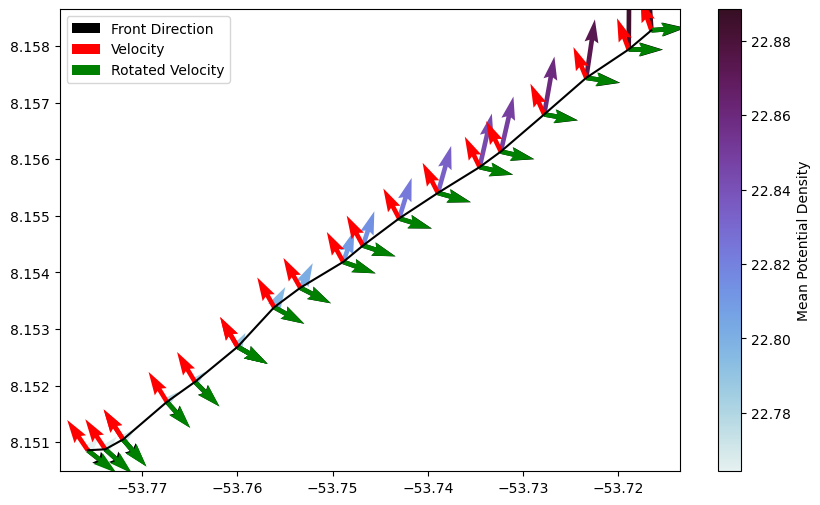

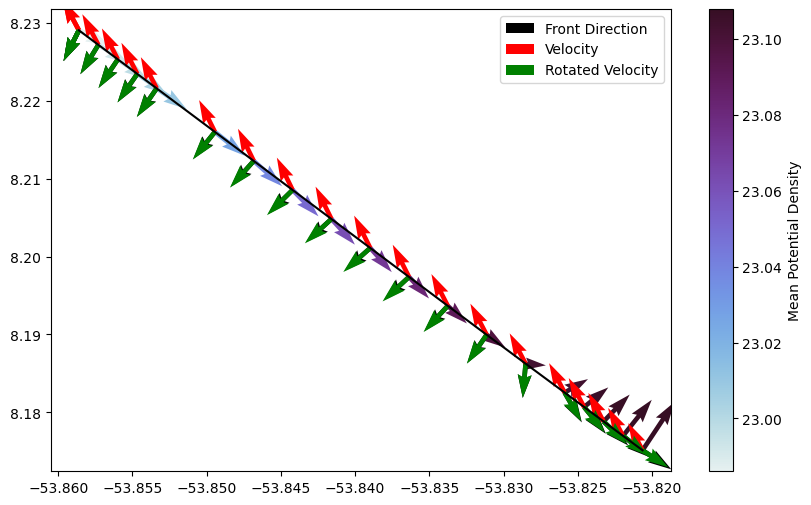

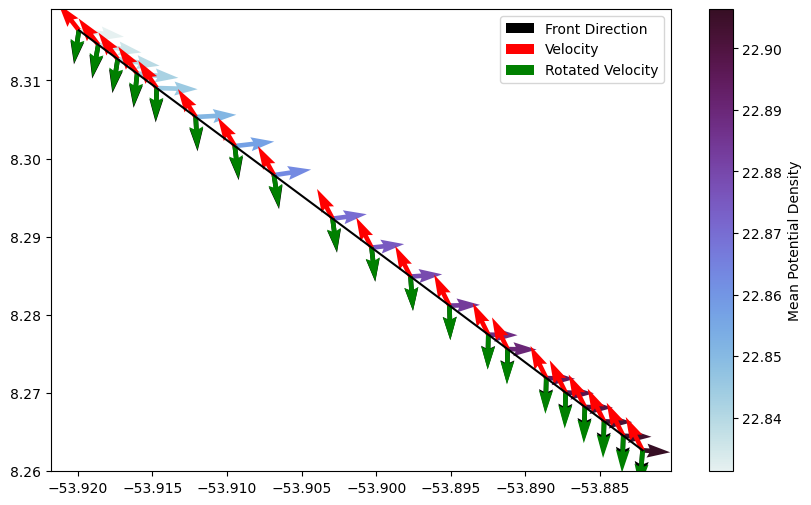

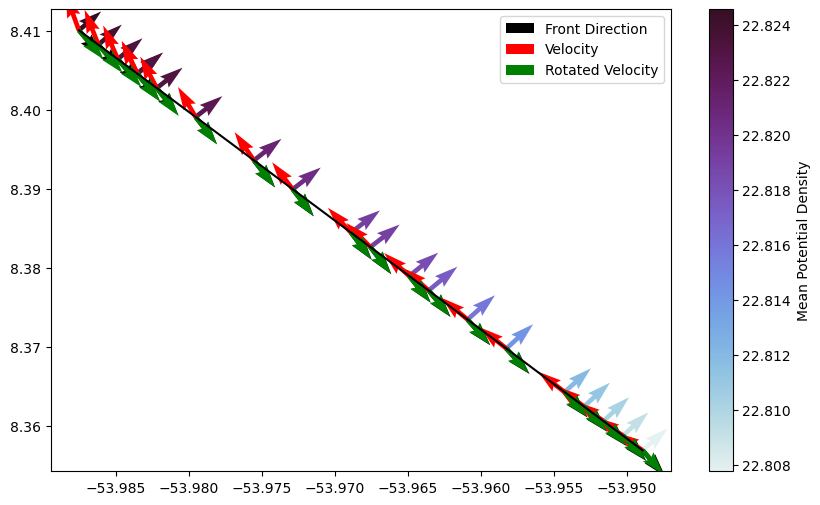

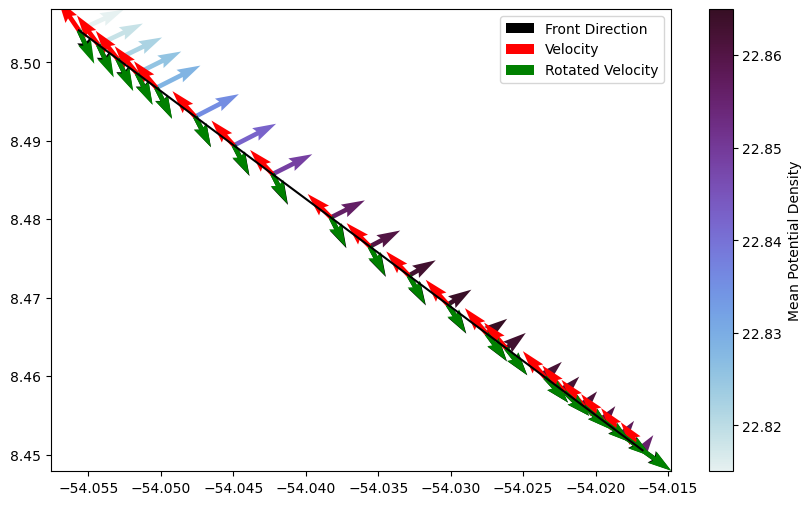

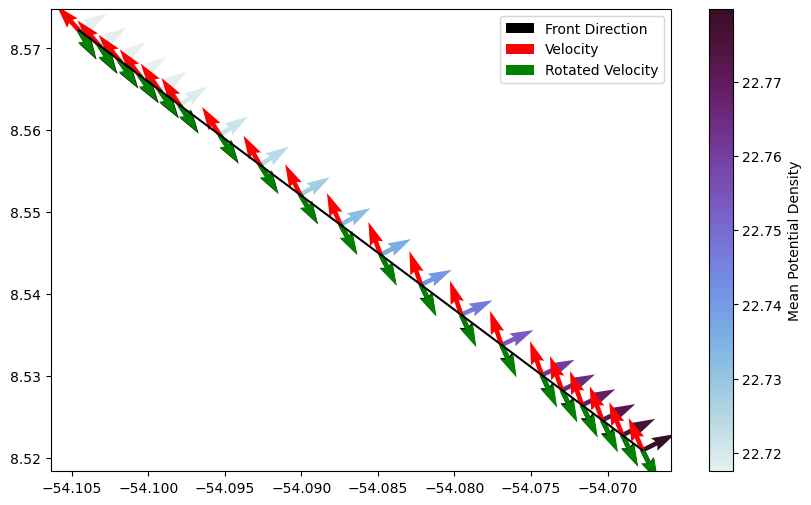

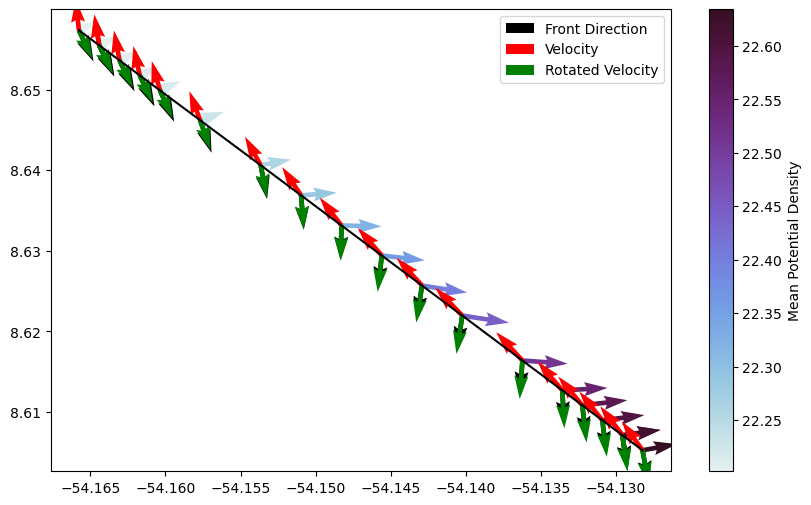

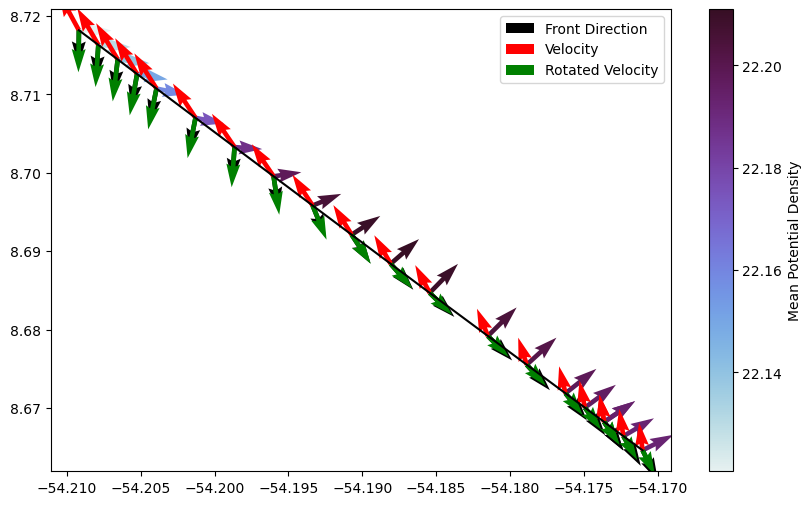

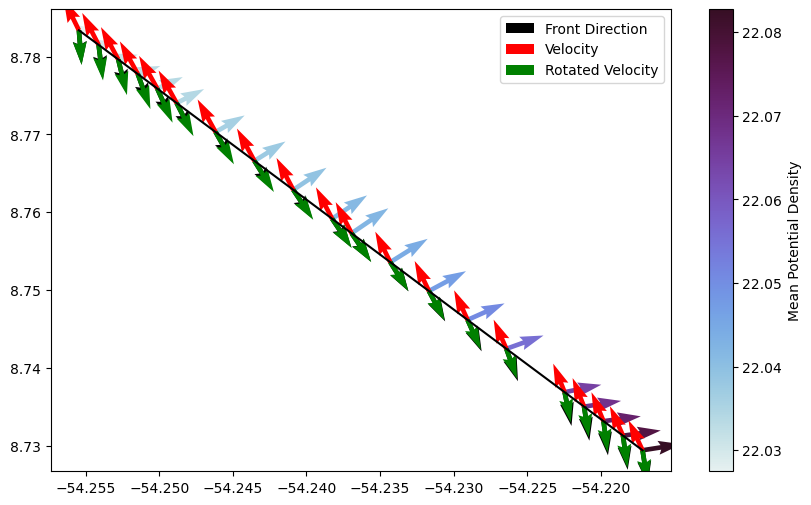

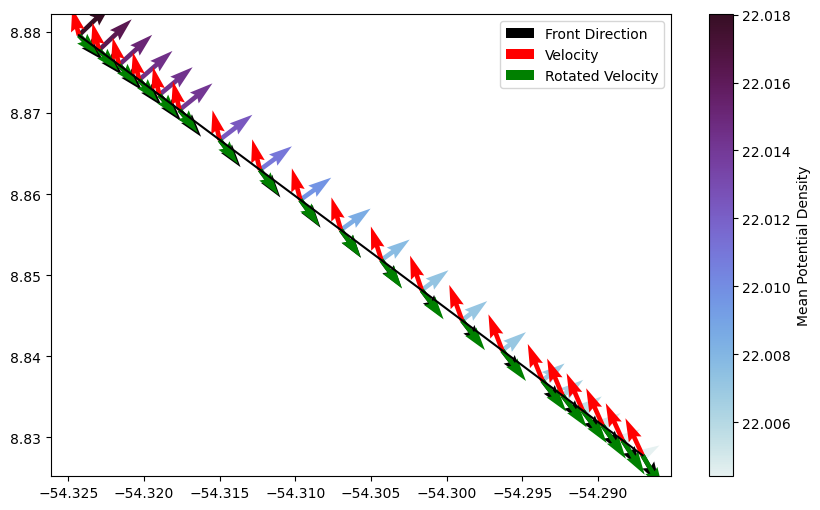

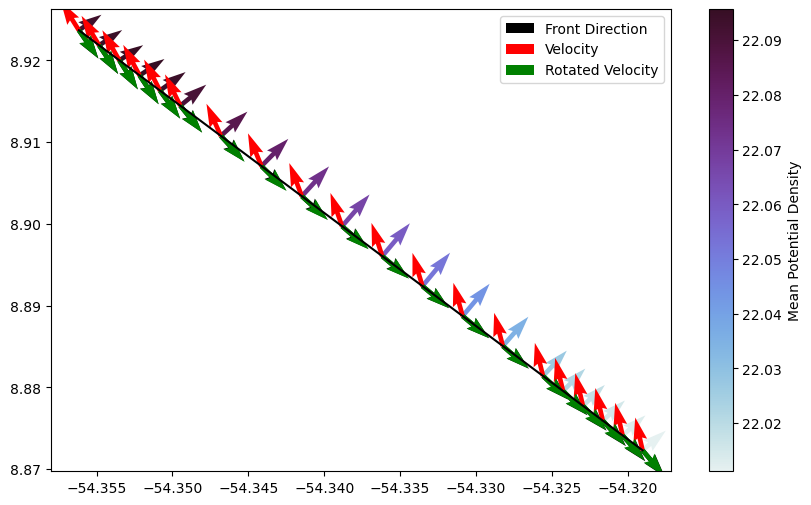

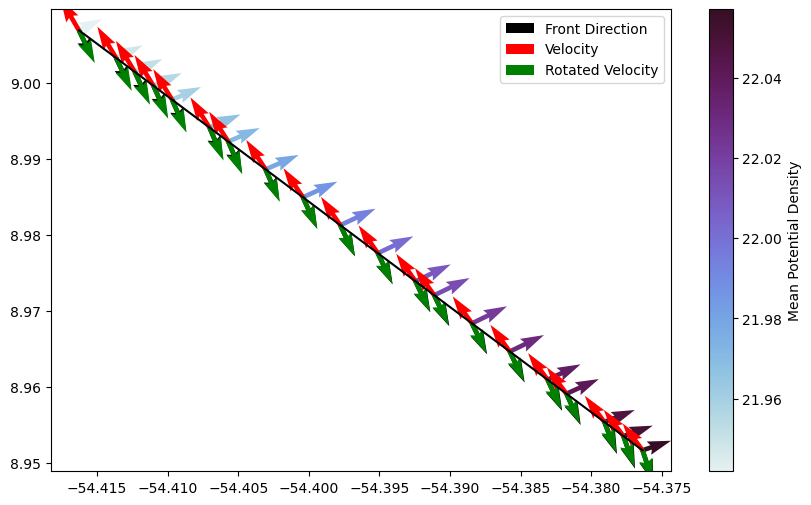

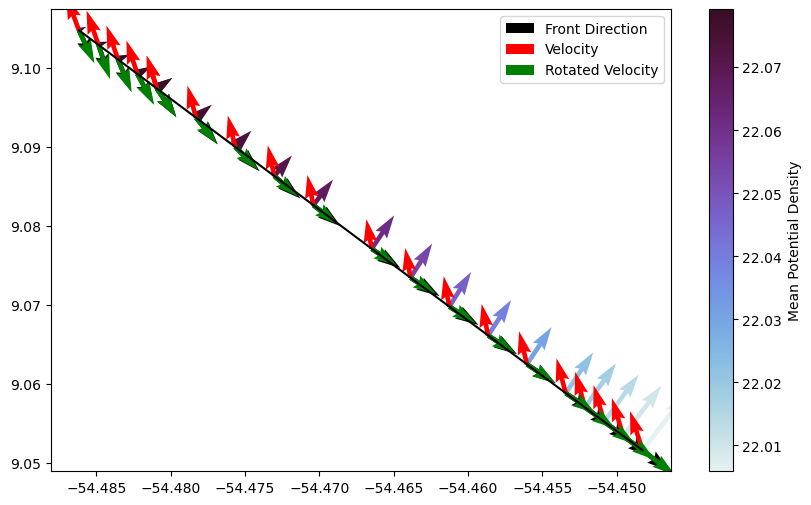

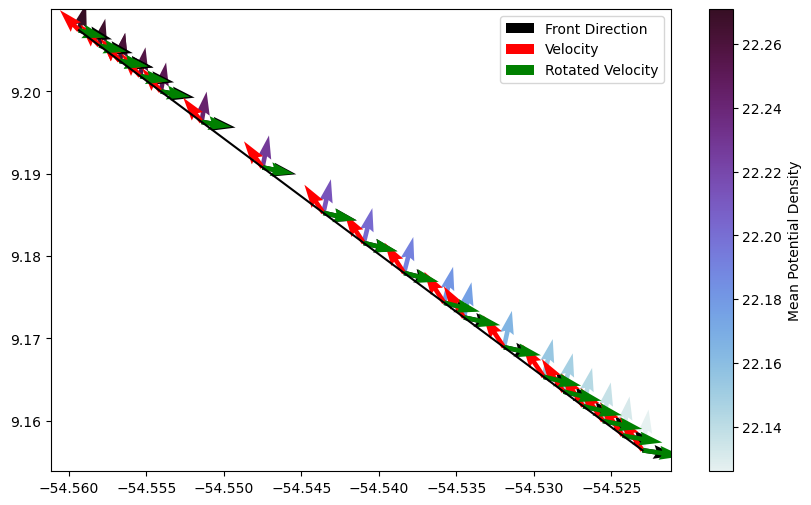

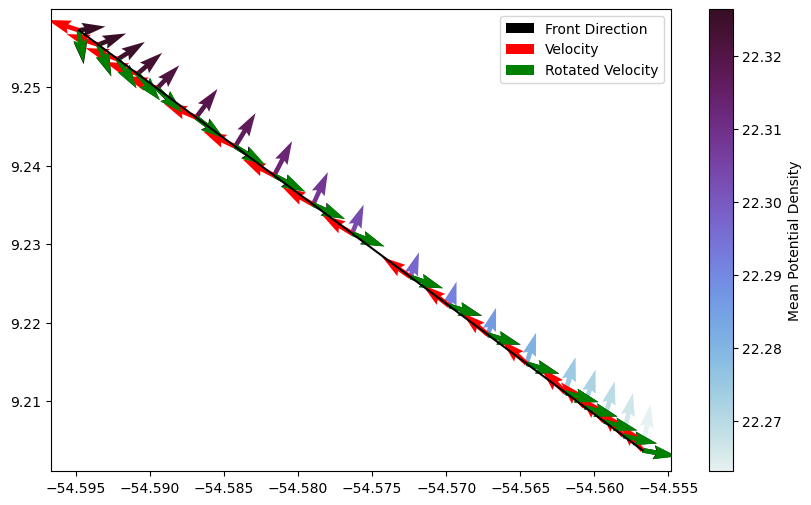

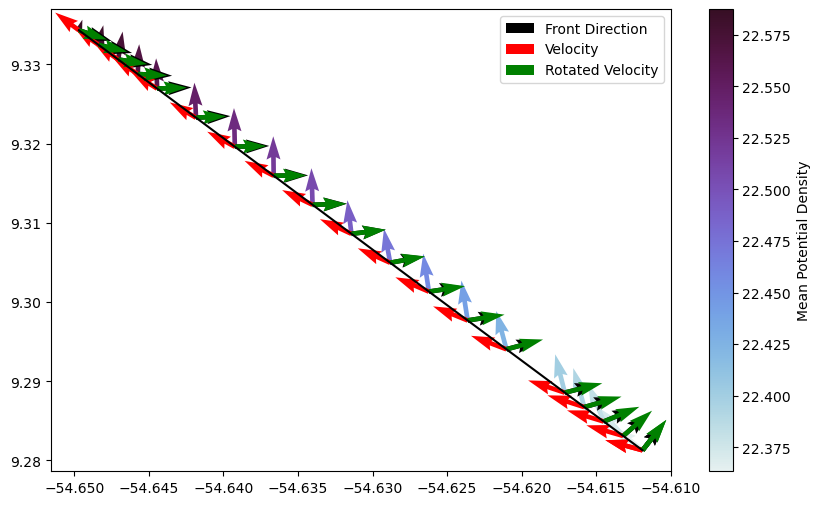

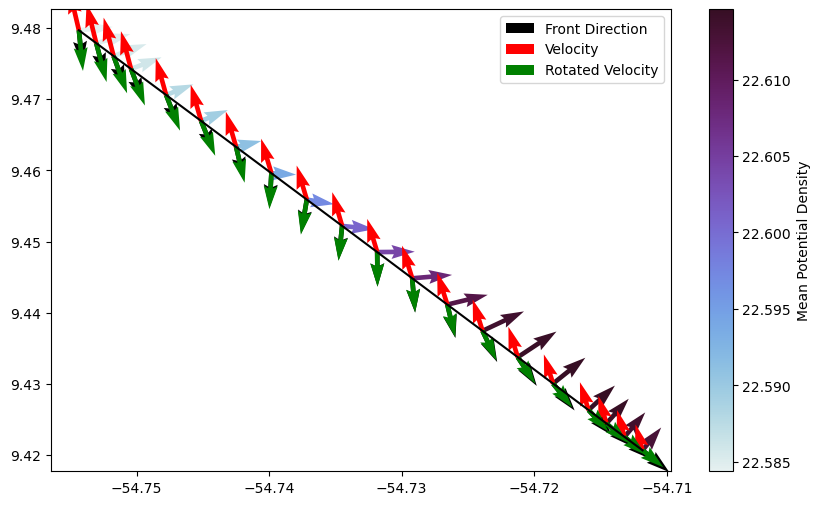

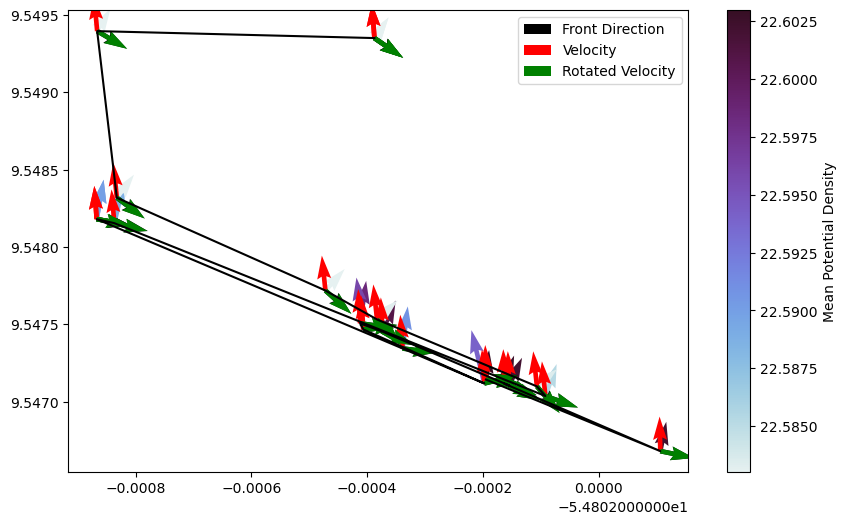

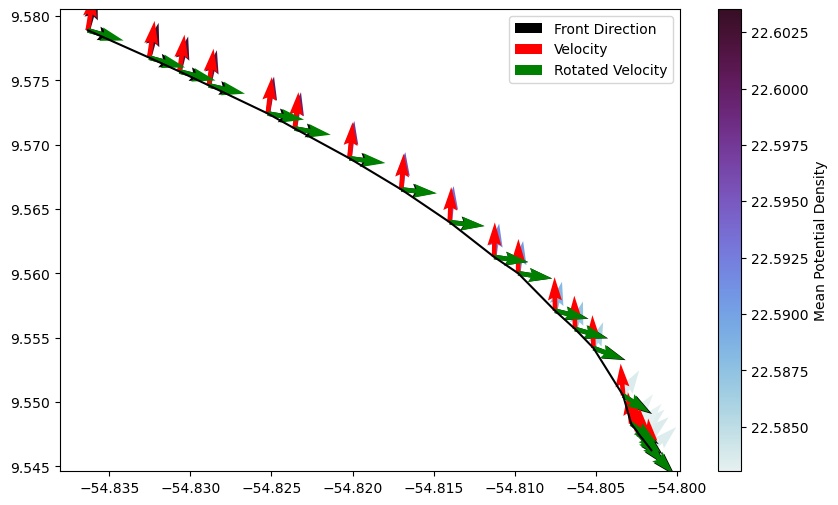

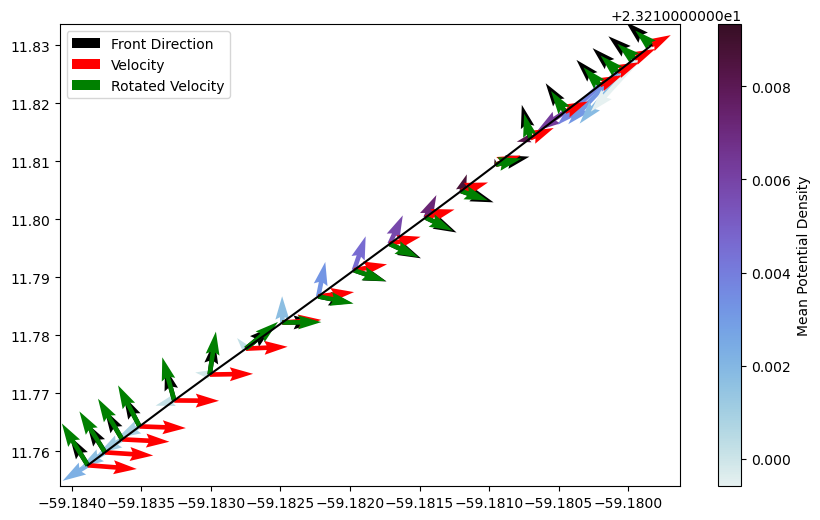

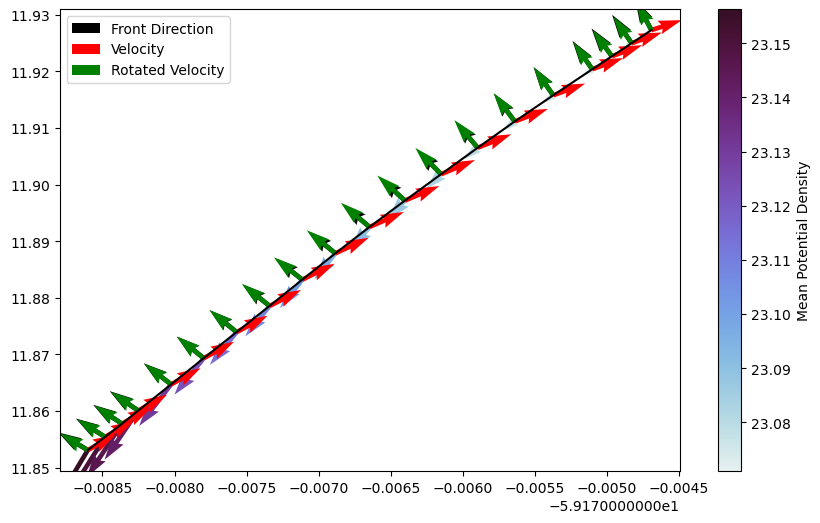

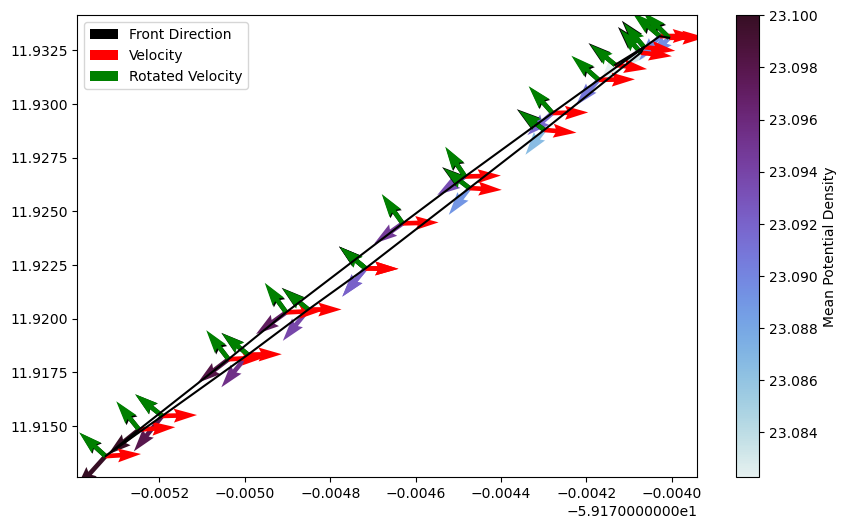

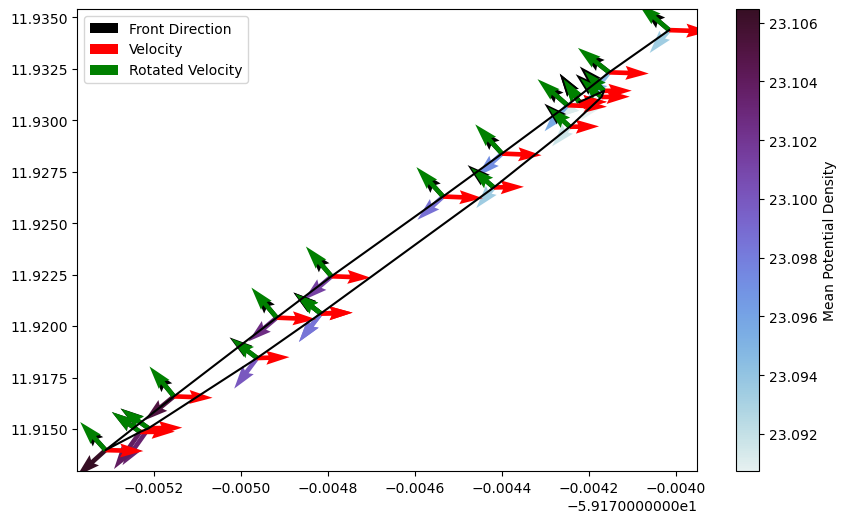

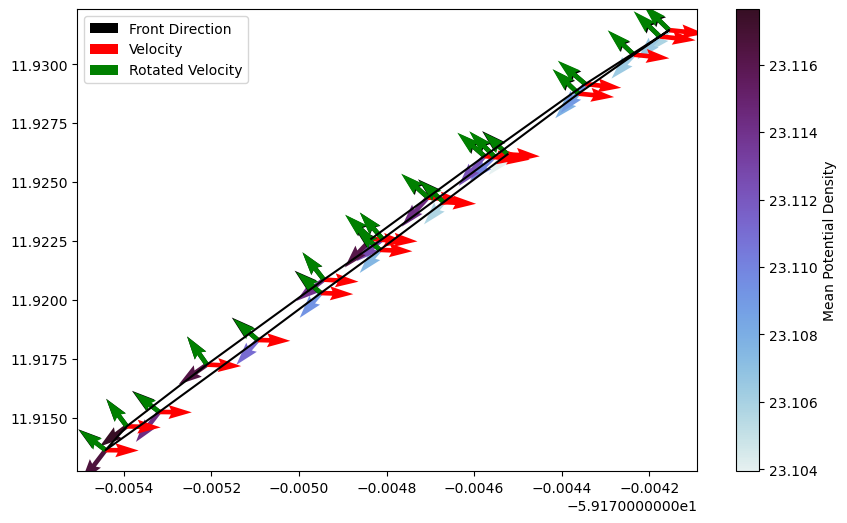

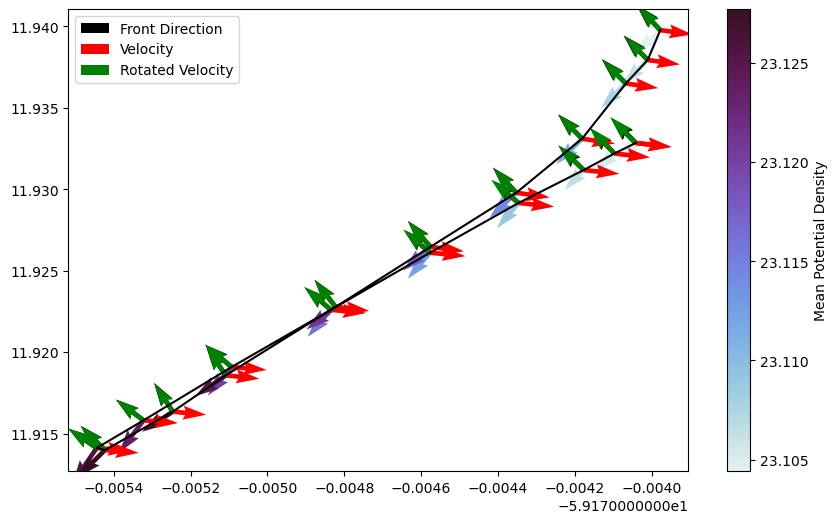

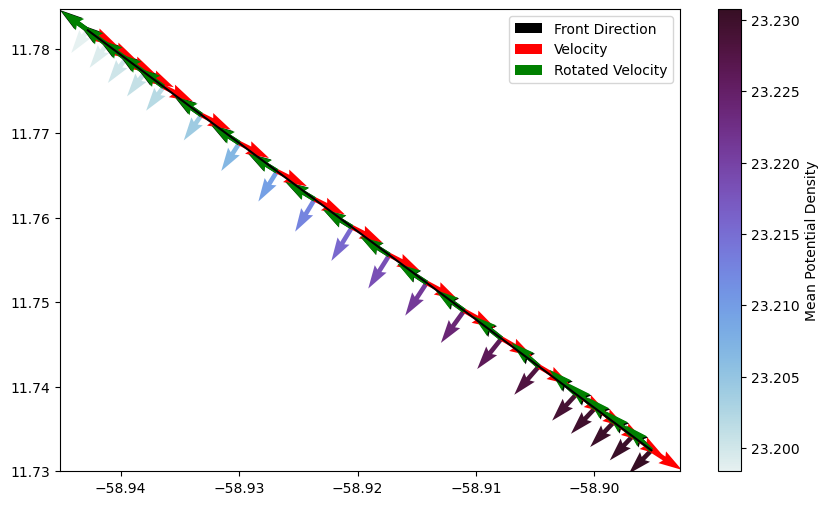

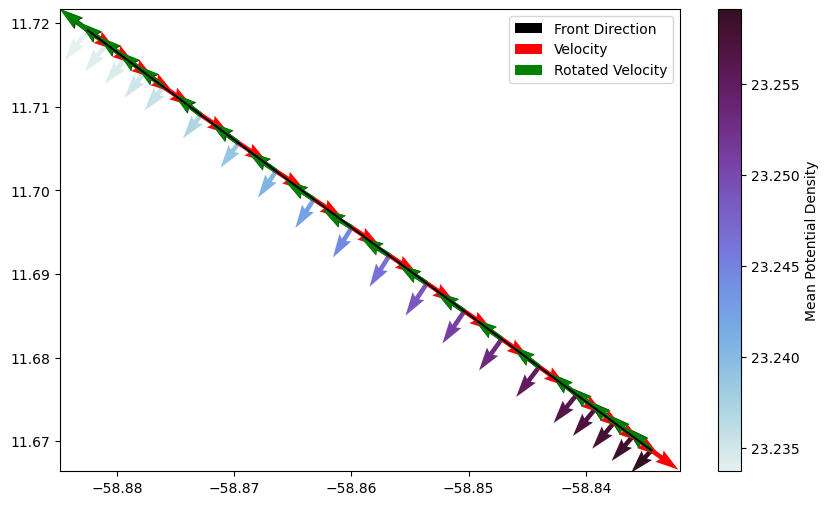

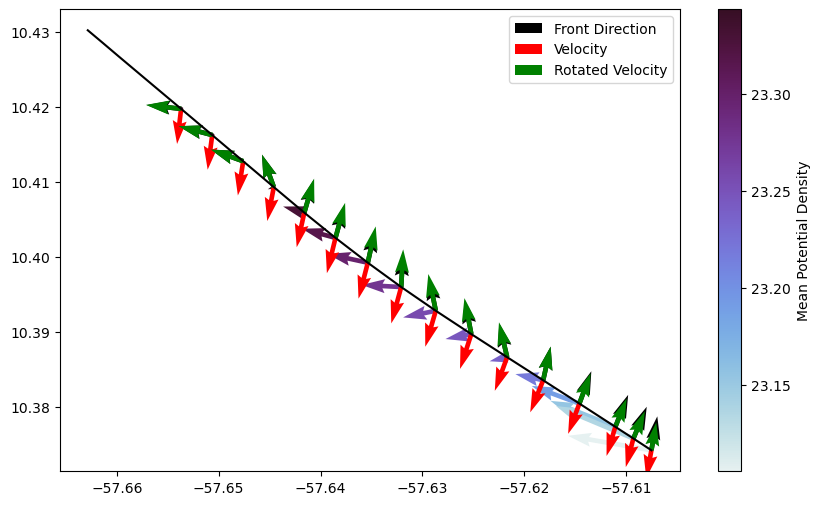

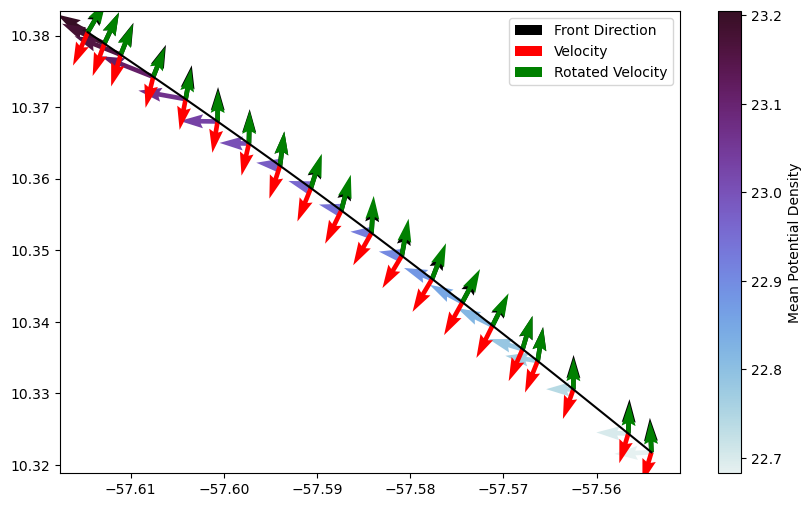

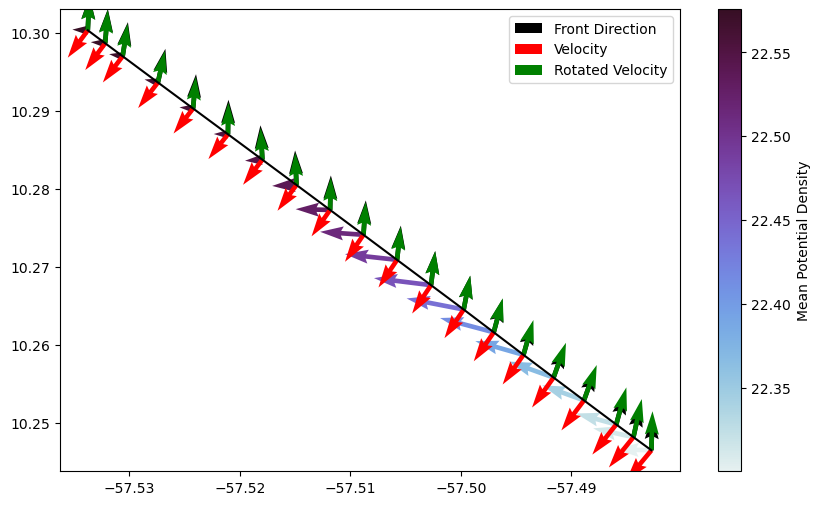

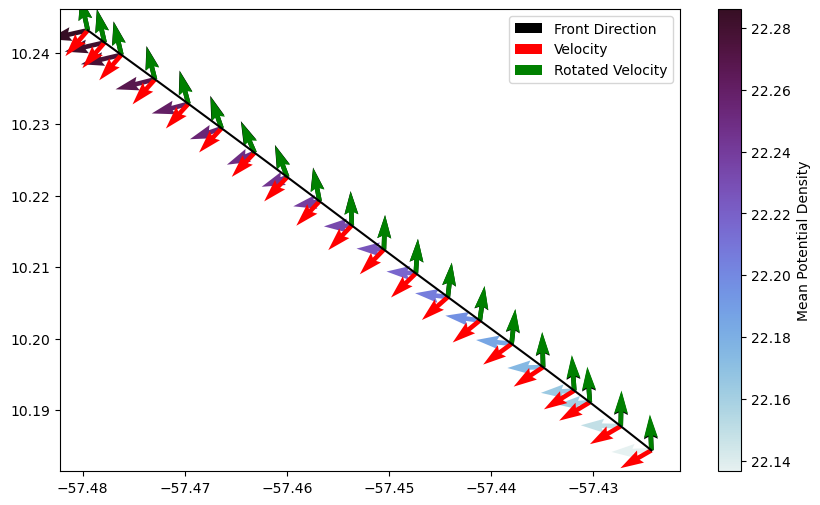

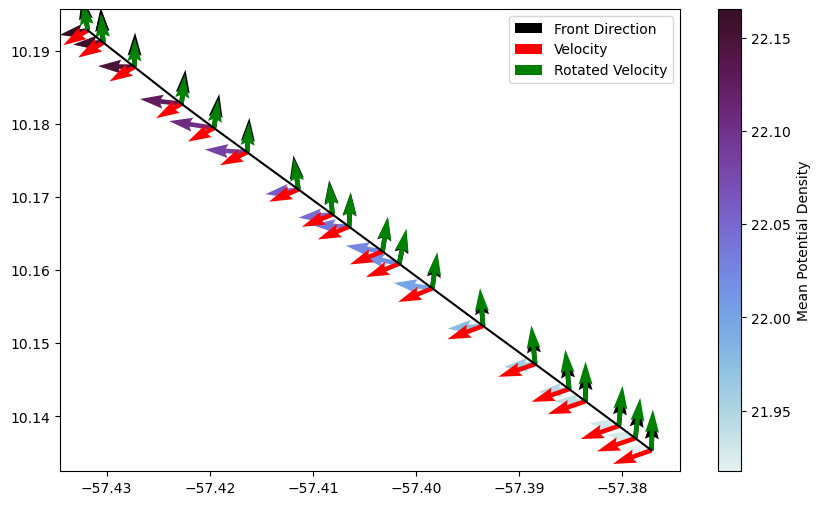

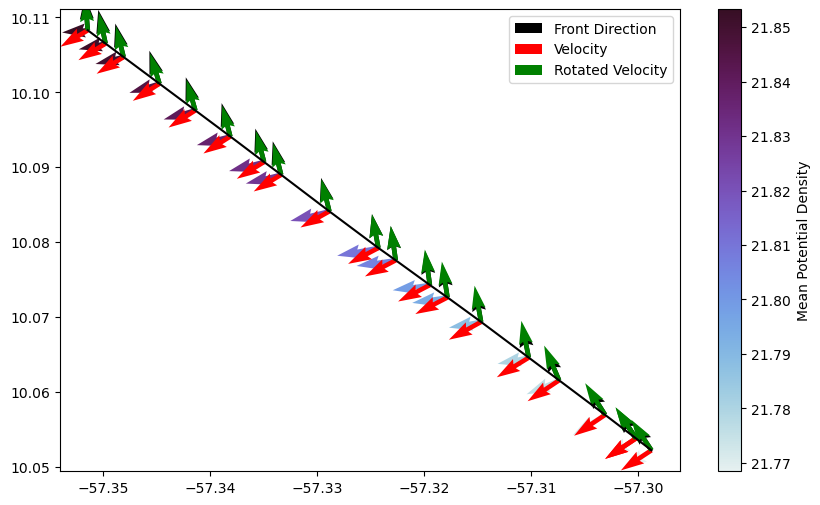

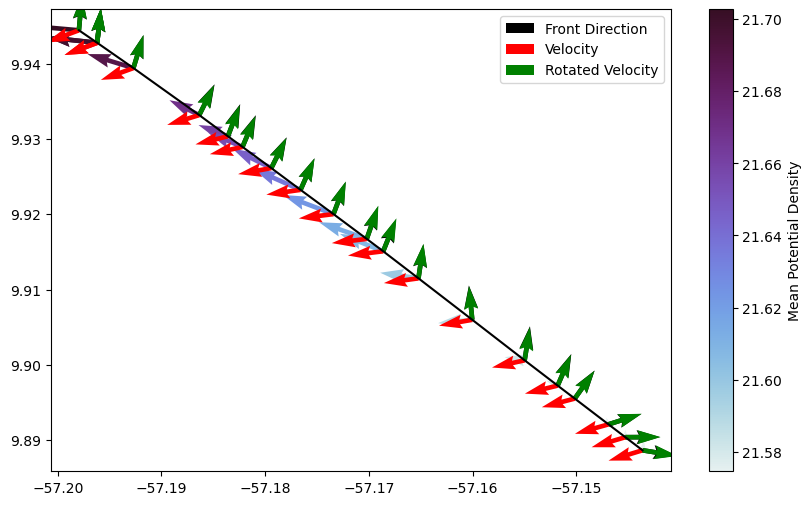

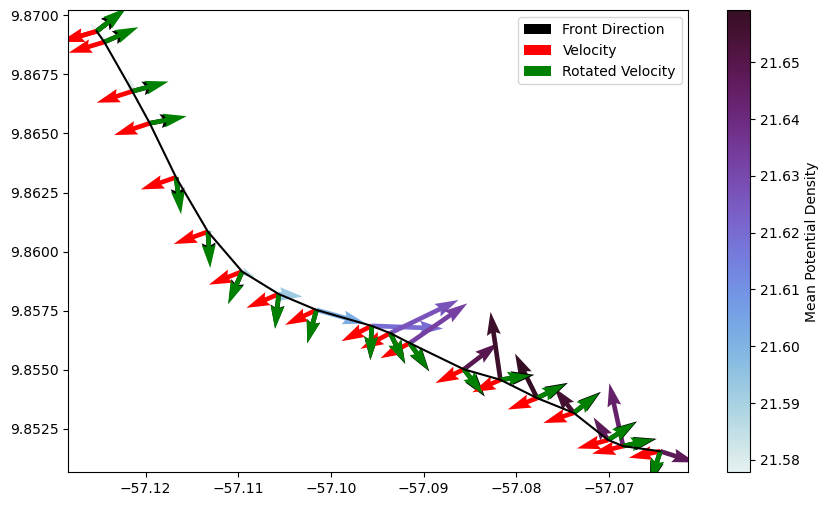

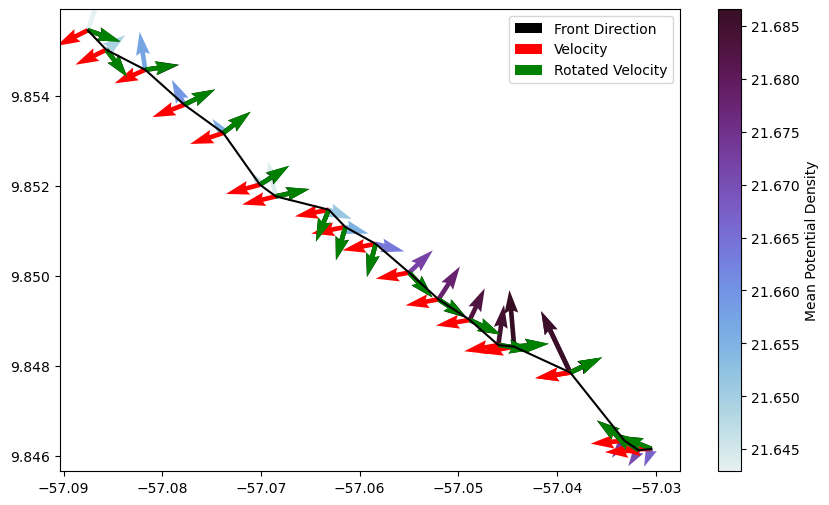

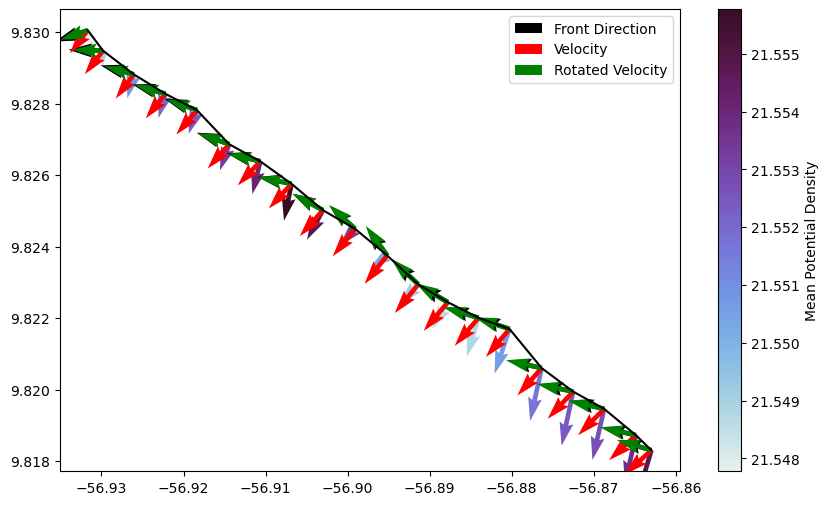

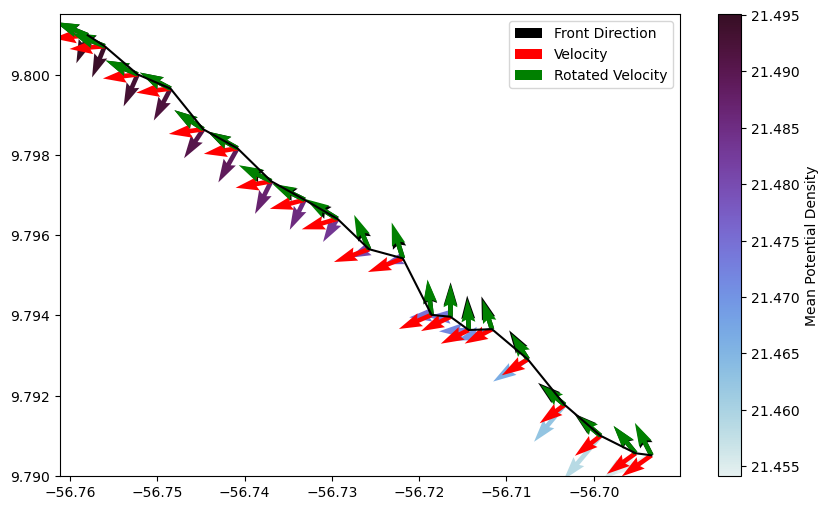

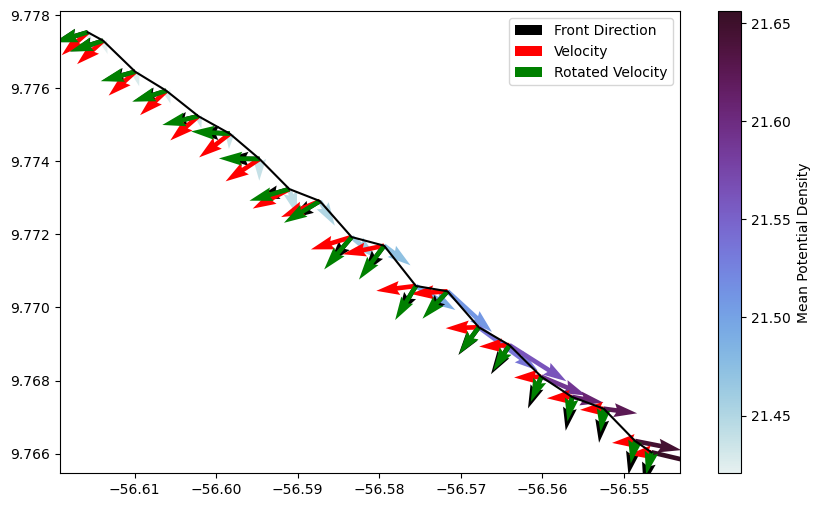

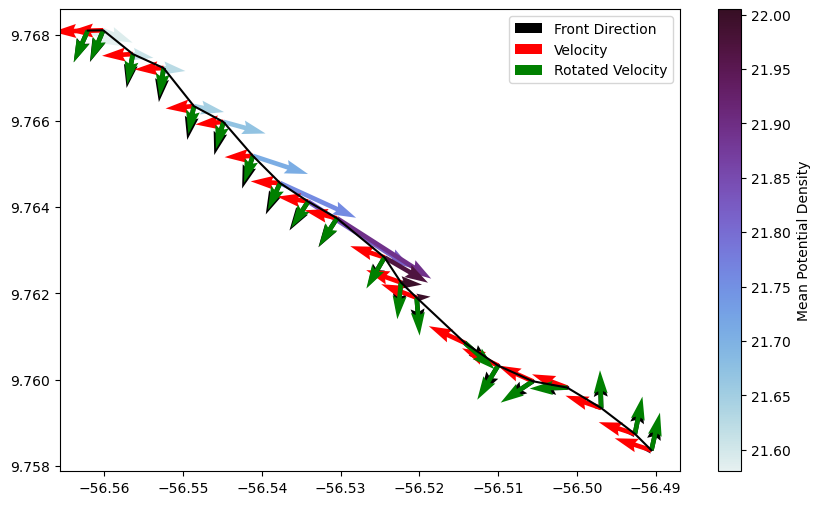

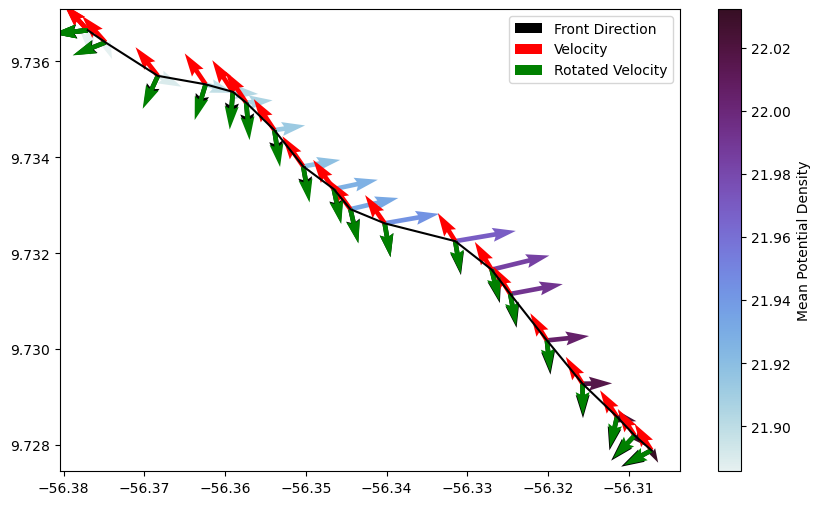

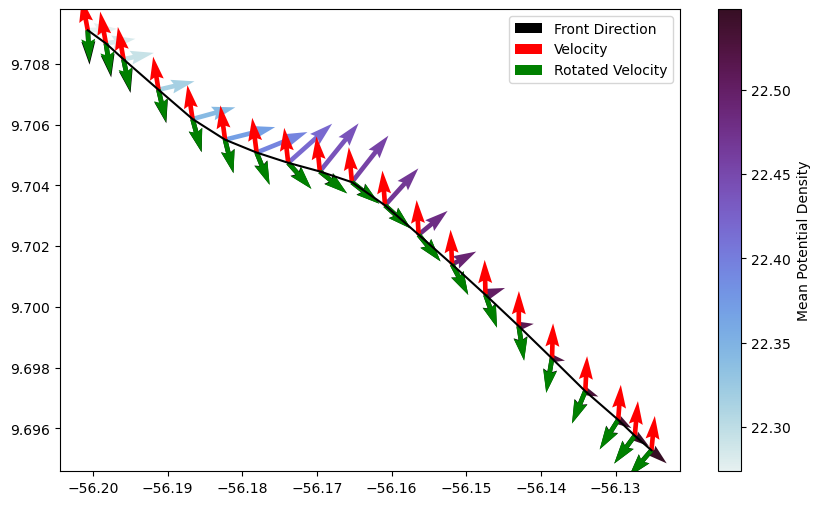

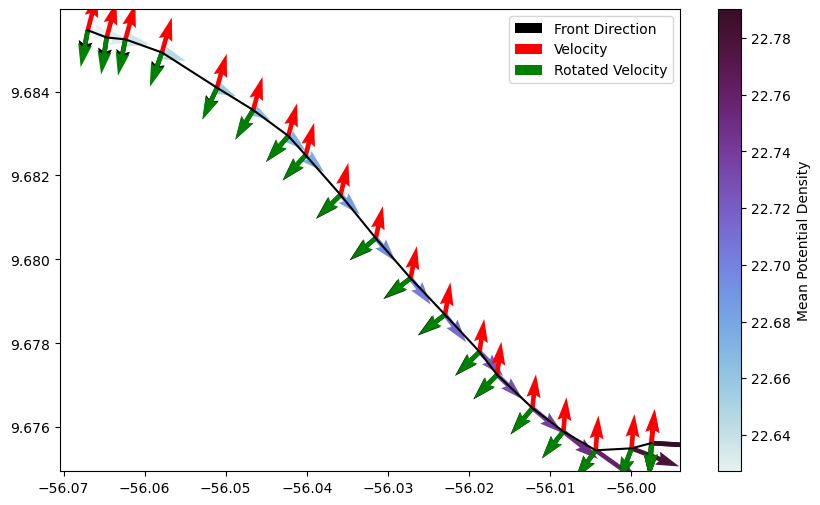

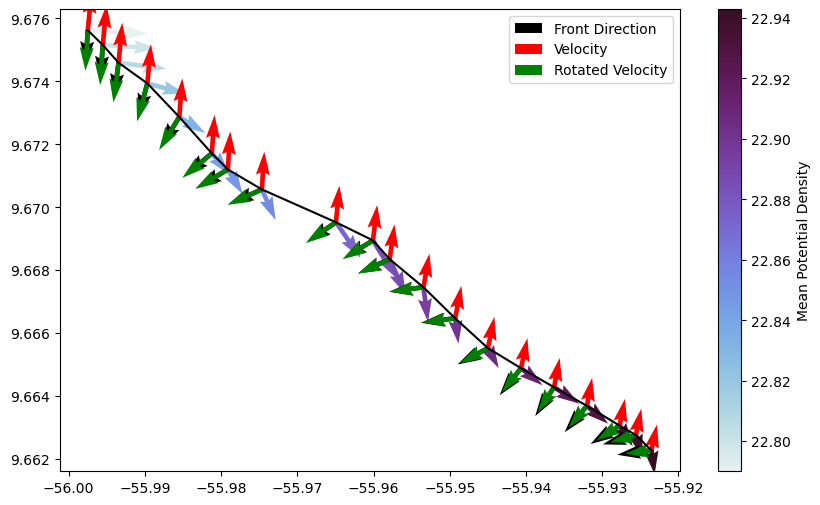

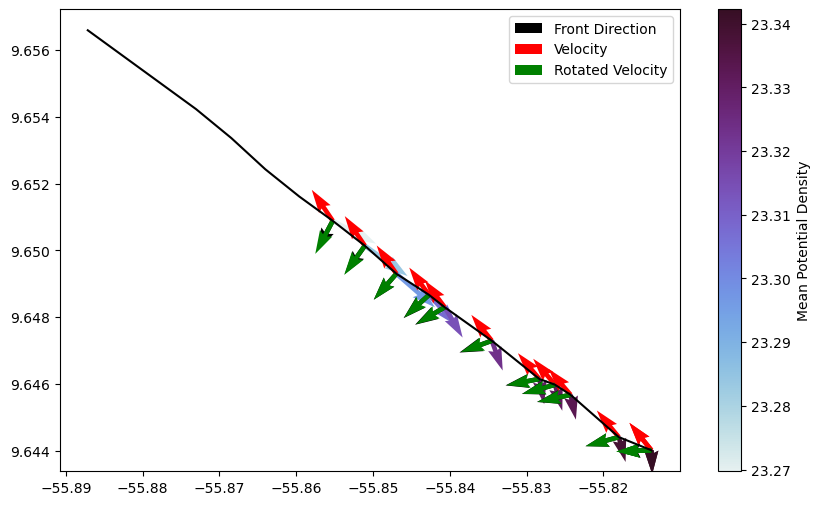

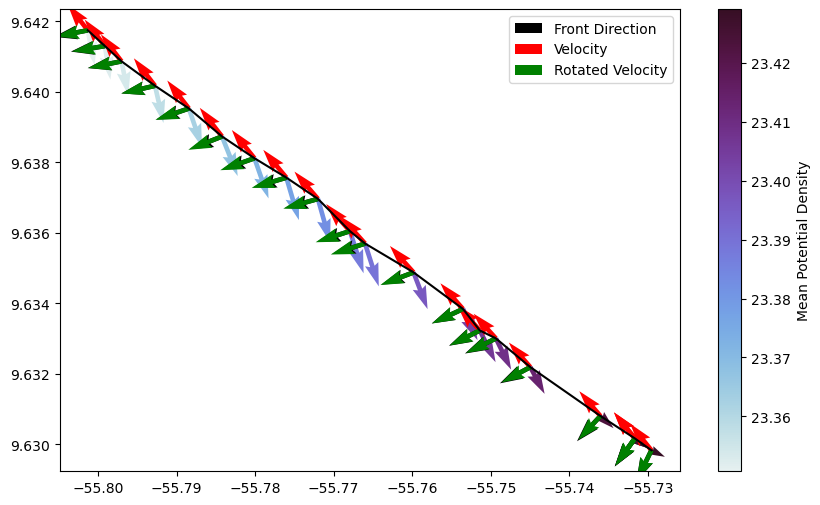

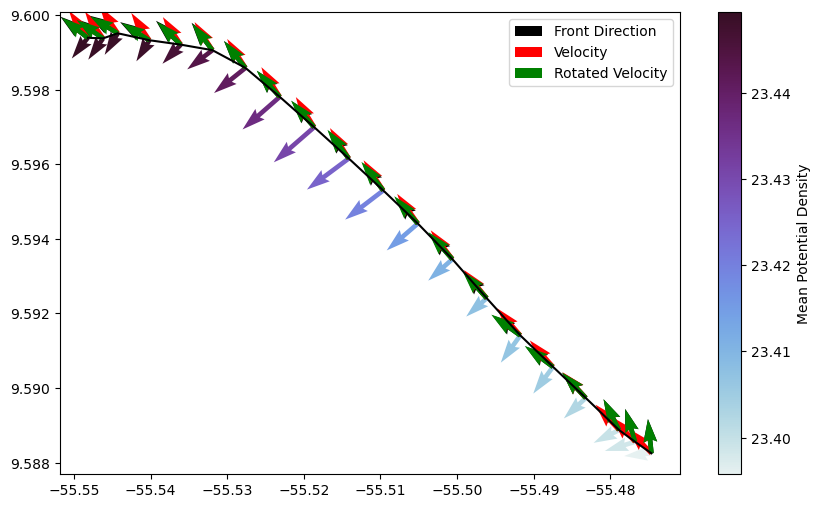

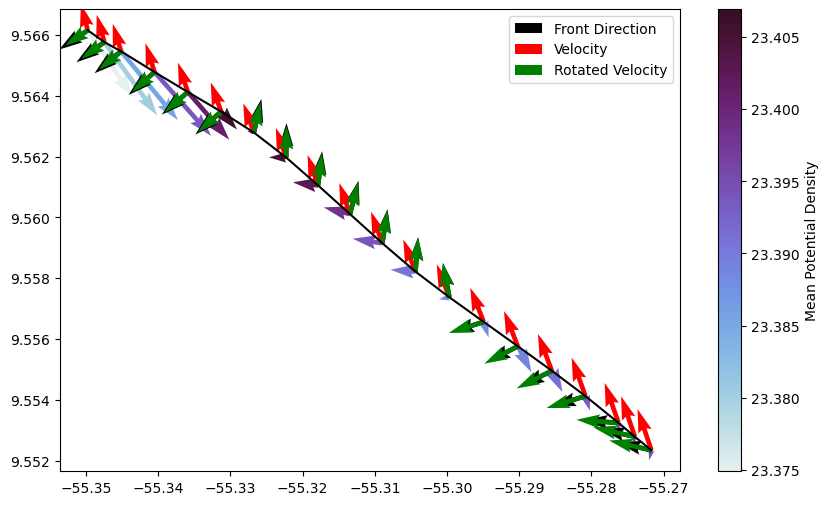

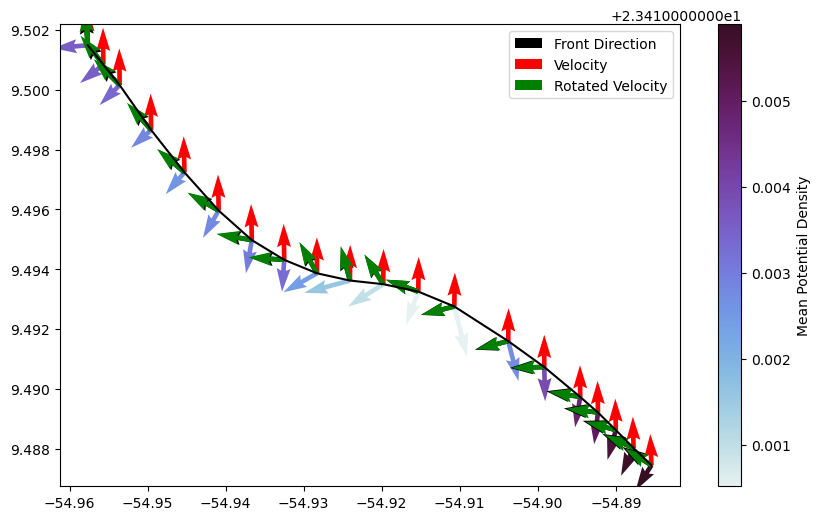

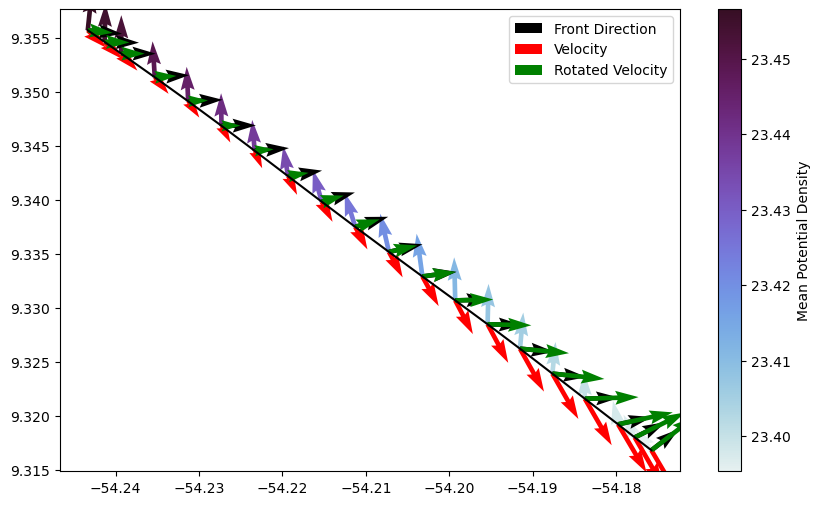

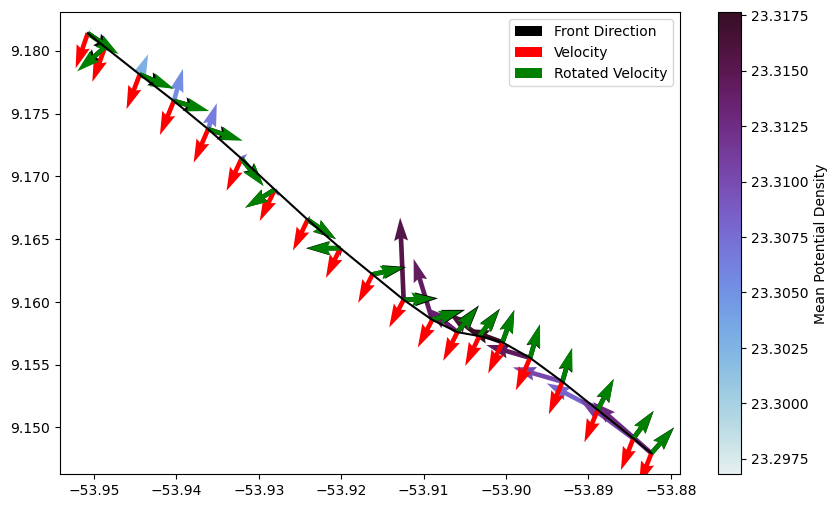

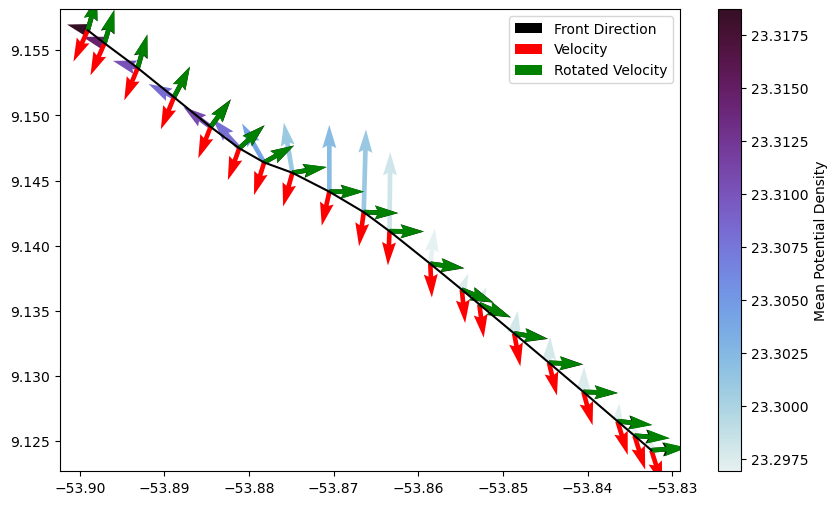

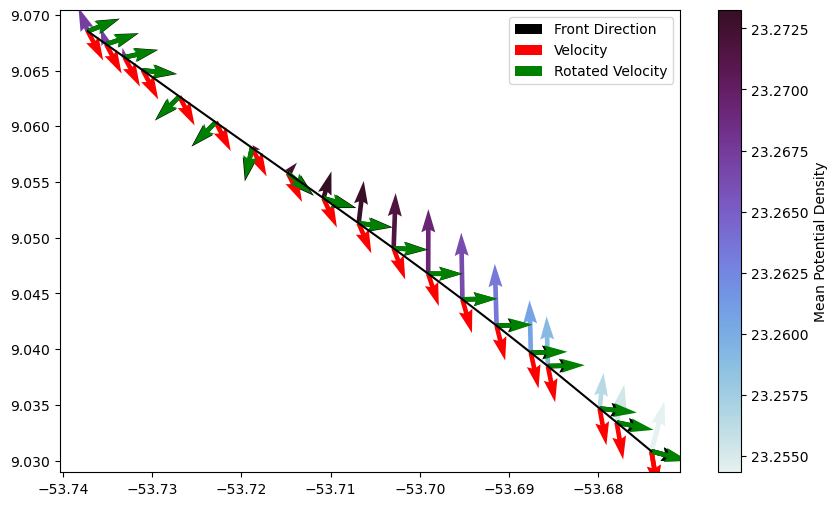

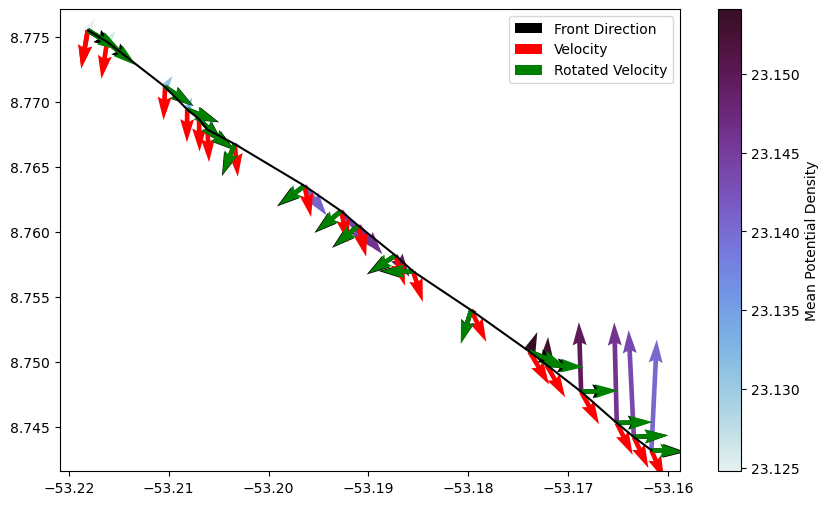

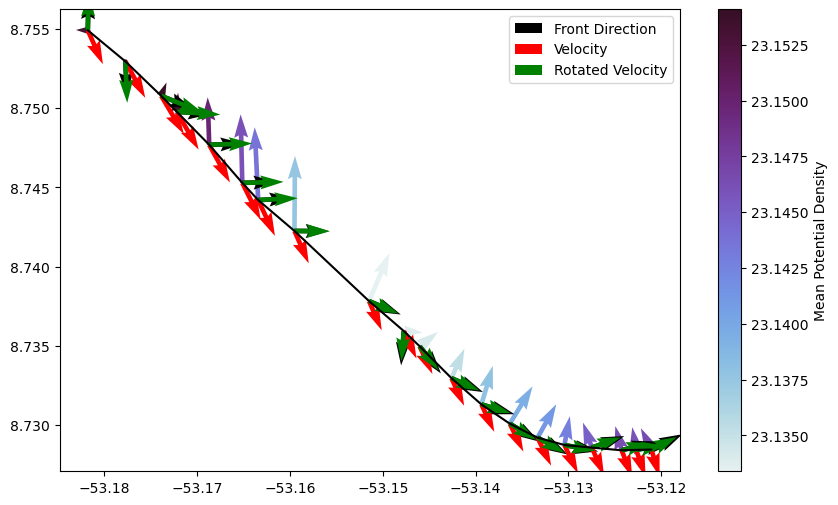

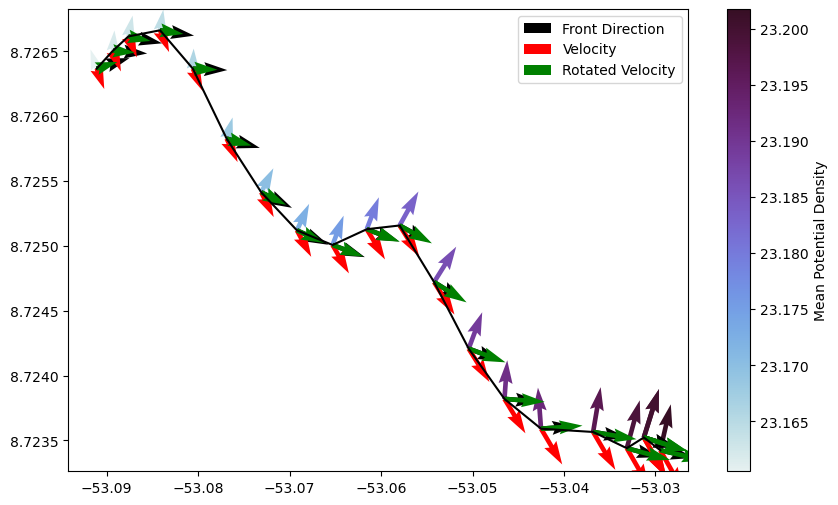

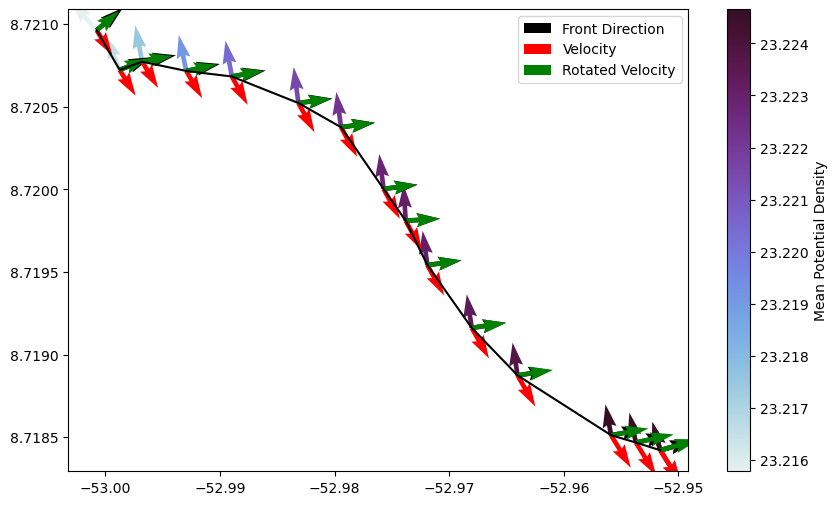

In [131]:
# create unit vector for front so we can visualize 
for i in range(len(coefs_nonadcp)):
    
    fig = plt.figure(figsize=(10,6))
    
    plt.plot(coefs_nonadcp[i].longitude,coefs_nonadcp[i].latitude,color='k')
    
    
    im = plt.quiver(coefs_nonadcp[i].longitude,
               coefs_nonadcp[i].latitude,
               coefs_nonadcp[i].rhox,
               coefs_nonadcp[i].rhoy,
               coefs_nonadcp[i].rho_mean,
               cmap = cmocean.cm.dense)
    
    plt.quiver(coefs_nonadcp[i].longitude,
               coefs_nonadcp[i].latitude,
               coefs_nonadcp[i].x,
               coefs_nonadcp[i].y,label='Front Direction')
    
    plt.quiver(coefs_adcp[i].longitude,
               coefs_adcp[i].latitude,
               coefs_adcp[i].isel(depth=20).u_mean,
               coefs_adcp[i].isel(depth=20).v_mean,color='r',label='Velocity')
    
    
    plt.quiver(coefs_nonadcp[i].longitude,
               coefs_nonadcp[i].latitude,
               coefs_adcp[i].u_prime.isel(depth=20),
               coefs_adcp[i].v_prime.isel(depth=20),color='g',label='Rotated Velocity')
    
    
    plt.colorbar(im,label='Mean Potential Density')
    plt.legend()

In [132]:
# calculate observered and estimated shear + density gradient 
for i in range(len(coefs_adcp)):
    # define constants for thermal wind equation 
    f = gsw.f(coefs_adcp[i]['latitude'])     # coriolis force 
    g = 9.81     # gravity 
    rho0 = 1025    # reference density constant 
    
    # calculate estimated shear from thermal wind equation 
    shear_est = (1/f)*(-g/rho0)*(coefs_nonadcp[i].rho_mag)
    
    # take magnitude (absolute value) of estimated shear to be comparable with observed 
    shear_est = np.absolute(shear_est)
    coefs_adcp[i]['shear_est'] = shear_est
    
    shear_obs = -coefs_adcp[i].vel_mag_prime.differentiate('depth')
    shear_obs = np.absolute(shear_obs)
    coefs_adcp[i]['shear_obs'] = shear_obs

    rho_grad_est = f * shear_obs * (-rho0/g)
    rho_mag_est = np.absolute(rho_grad_est)
    coefs_nonadcp[i]['rho_grad_est'] = rho_mag_est


Text(0.5, 0, 'Observed Shear')

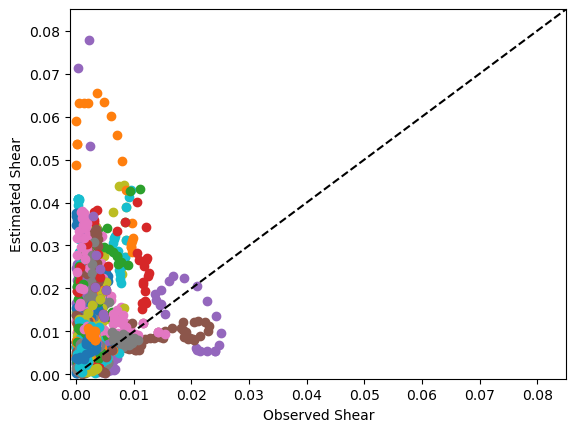

In [133]:
for i in range(len(coefs_adcp)):
    plt.scatter(coefs_adcp[i].shear_obs.isel(depth=0),coefs_adcp[i].shear_est)
plt.ylim(-0.001,0.085)
plt.xlim(-0.001,0.085)
plt.plot([0,0.085],[0,0.085],color='k',linestyle='dashed')
plt.ylabel('Estimated Shear')
plt.xlabel('Observed Shear')

Text(0.5, 0, 'Observed Shear')

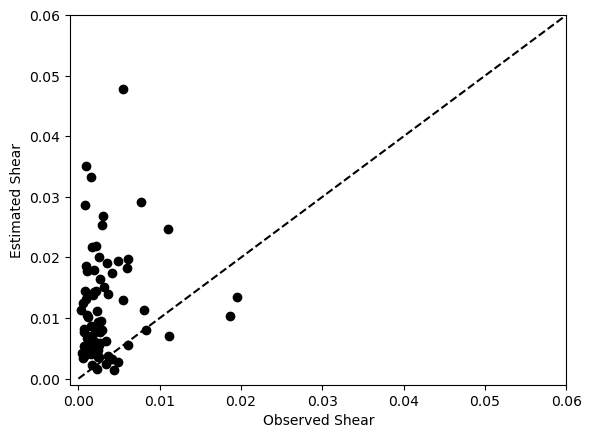

In [138]:
for i in range(len(coefs_adcp)):
    plt.scatter(coefs_adcp[i].shear_obs.isel(depth=0).mean(),coefs_adcp[i].shear_est.mean(),color='k')
plt.ylim(-0.001,0.06)
plt.xlim(-0.001,0.06)
plt.plot([0,0.085],[0,0.085],color='k',linestyle='dashed')
plt.ylabel('Estimated Shear')
plt.xlabel('Observed Shear')

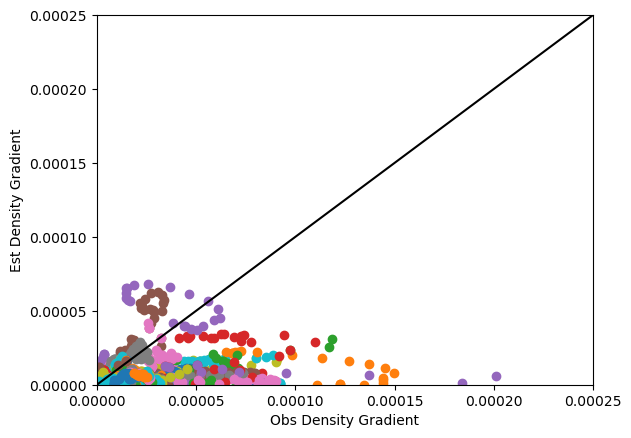

In [135]:
for i in range(len(coefs_nonadcp)):
    plt.scatter(coefs_nonadcp[i].rho_mag,coefs_nonadcp[i].rho_grad_est.isel(depth=0))
# plt.scatter(shear_est.isel(depth=0),shear_obs1.isel(depth=0))
plt.xlabel('Obs Density Gradient')
plt.ylabel('Est Density Gradient')
plt.xlim(0,2.5e-4)
plt.ylim(0,2.5e-4)
plt.plot([0,3e-4],[0,3e-4],color='k')

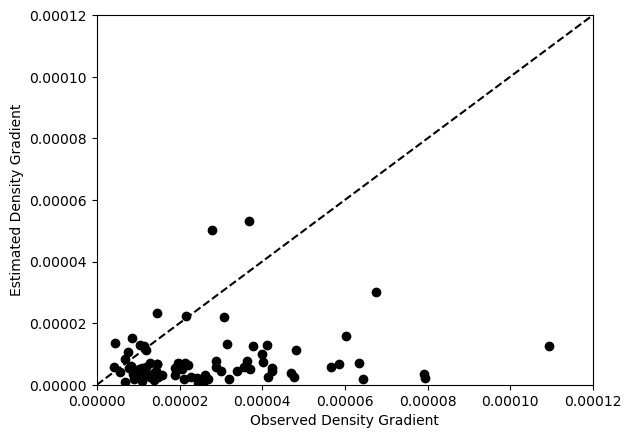

In [142]:
for i in range(len(coefs_nonadcp)):
    plt.scatter(coefs_nonadcp[i].rho_mag.mean(),coefs_nonadcp[i].rho_grad_est.isel(depth=0).mean(),color='k')
# plt.scatter(shear_est.isel(depth=0),shear_obs1.isel(depth=0))
plt.xlabel('Observed Density Gradient')
plt.ylabel('Estimated Density Gradient')
plt.xlim(0,1.2e-4)
plt.ylim(0,1.2e-4)
plt.plot([0,1.5e-4],[0,1.5e-4],color='k',linestyle='dashed')

#### piece wise

In [74]:
coefs_adcp_front = coefs_adcp[0]
coefs_nonadcp_front = coefs_nonadcp[0]

In [75]:
# define constants for thermal wind equation 
f = gsw.f(coefs_adcp_front['latitude'])     # coriolis force 
g = 9.81     # gravity 
rho0 = 1025    # reference density constant 

In [76]:
# calculate estimated shear from thermal wind equation 
shear_est = (1/f)*(-g/rho0)*(coefs_nonadcp_front.rho_mag)

In [80]:
# take magnitude (absolute value) of estimated shear to be comparable with observed 
shear_est = np.absolute(shear_est)

In [21]:
# shear_est = shear_est.expand_dims(dim={'depth':coefs_adcp_front.depth})    #broadcast to all depths?

In [77]:
shear_obs = -coefs_adcp_front.vel_mag_prime.differentiate('depth')

In [33]:
shear_obs = np.absolute(shear_obs)

In [34]:
coefs_adcp_front.vel_mag_prime.differentiate('depth')

<xarray.DataArray 'vel_mag_prime' (depth: 24, time: 20)>
array([[ 3.07551644e-04,  3.14255232e-04, -2.21518715e-04,
        -2.51678380e-03, -3.51571836e-03, -3.04820287e-03,
        -1.80594207e-03, -1.21563437e-03, -1.42071590e-03,
        -8.53460534e-04, -1.53987178e-03, -2.18951721e-03,
        -2.29534109e-03, -3.82882649e-03, -5.35478754e-03,
        -2.24396783e-03,  1.73348213e-03,  2.83846098e-03,
        -1.15157688e-03, -3.65751836e-03],
       [ 4.23399306e-04, -3.08618923e-04, -1.84950083e-03,
        -3.06755128e-03, -3.53756820e-03, -3.12589682e-03,
        -1.61483240e-03, -1.02349971e-03, -8.44619906e-04,
        -1.31915325e-03, -2.03710525e-03, -2.47027175e-03,
        -2.36165037e-03, -2.42915915e-03, -2.12315121e-04,
         2.14170529e-03,  3.47185260e-03,  2.24780904e-03,
        -4.70910091e-04, -1.42822535e-03],
       [-1.37934182e-03, -1.78461004e-03, -1.99200759e-03,
        -2.36840856e-03, -2.29990664e-03, -2.39642563e-03,
        -2.51050894e-03, -1.83945197e-03, -1.38935881e-03,
        -3.62683441e-03, -3.39774516e-03, -1.97918703e-03,
        -5.27421327e-04,  8.47558917e-04,  4.82935901e-03,
         5.51115668e-03,  4.05234127e-03,  1.27417032e-03,
...
        -3.94639462e-03, -2.90481887e-03, -3.35888603e-03,
        -4.34752895e-03, -4.11930453e-03, -4.61270017e-03,
        -3.72037984e-03, -2.02543233e-03,  8.12105711e-04,
         1.54881112e-03,  1.87771206e-03,  1.91273657e-03,
         1.71100031e-03,  1.03897036e-03,  3.71388902e-04,
         2.65294676e-04, -5.62314728e-05],
       [-5.30266938e-04, -1.37513309e-03, -1.44500182e-03,
        -2.34441617e-03, -2.20915429e-03, -2.29771666e-03,
        -3.44363531e-03, -3.17807329e-03, -2.99112663e-03,
        -1.84778412e-03,  1.11815671e-04,  1.32456596e-03,
         1.77216088e-03,  1.58409117e-03,  6.62064655e-04,
         4.68651893e-04, -1.14260848e-04, -7.15853125e-04,
        -8.88139735e-04, -1.06703830e-03],
       [ 9.84364660e-04,  4.27264765e-04,  6.46379550e-05,
        -1.15697138e-03, -1.37454789e-03, -9.33322793e-04,
        -2.36071840e-03, -2.22431955e-03, -1.89713434e-03,
        -1.27949638e-03, -6.18822063e-05,  9.21384771e-04,
         9.95437265e-04,  5.49097456e-04, -2.95161024e-04,
        -1.10814451e-03, -1.53692875e-03, -1.97063129e-03,
        -1.87630417e-03, -1.86460715e-03]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-28T19:15:12.558177792 ... 2020-0...
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 44.24 46.24 48.24 50.24
    longitude  (time) float64 -50.13 -50.13 -50.13 ... -50.09 -50.09 -50.09
    latitude   (time) float64 7.871 7.872 7.873 7.876 ... 7.885 7.885 7.884
    distance   (time) float64 ...

In [35]:
shear_u = -coefs_adcp_front.u_prime.differentiate('depth')
shear_v = -coefs_adcp_front.v_prime.differentiate('depth')
shear_obs1 = np.sqrt(shear_u**2 + shear_v**2)

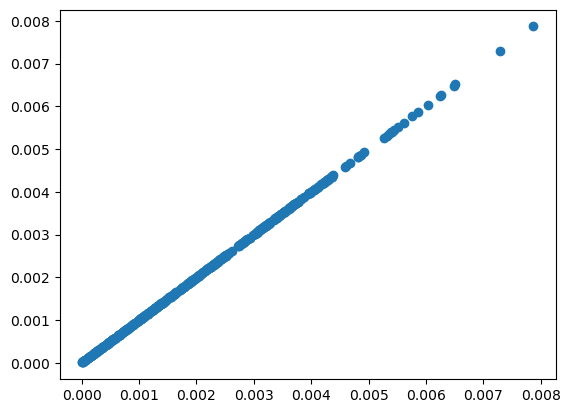

In [36]:
plt.scatter(shear_obs, shear_obs1)

Text(0.5, 0, 'Observed Shear')

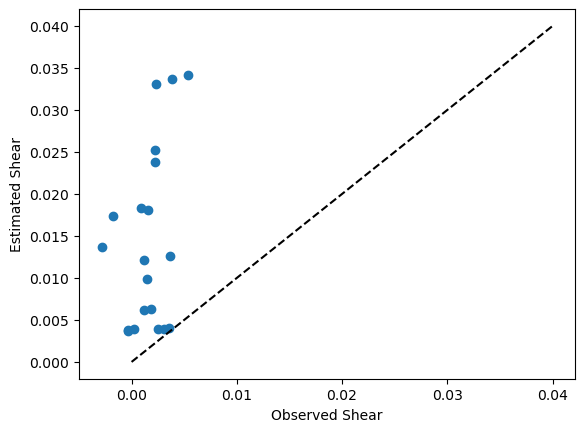

In [81]:
plt.scatter(shear_obs.isel(depth=0),shear_est)
# plt.ylim(0,0.04)
# plt.xlim(0,0.04)
plt.plot([0,0.04],[0,0.04],color='k',linestyle='dashed')
plt.ylabel('Estimated Shear')
plt.xlabel('Observed Shear')

Text(0.5, 0, 'Observed Shear')

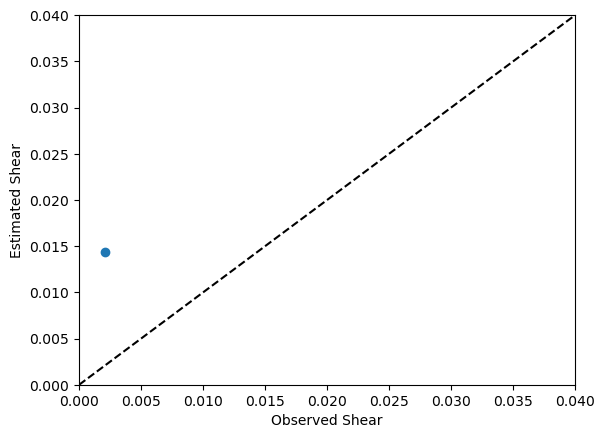

In [45]:
plt.scatter(shear_obs.isel(depth=0).mean(),shear_est.mean())
plt.ylim(0,0.04)
plt.xlim(0,0.04)
plt.plot([0,0.04],[0,0.04],color='k',linestyle='dashed')
plt.ylabel('Estimated Shear')
plt.xlabel('Observed Shear')

In [46]:
rho_grad_est = f * shear_obs * (-rho0/g)
rho_mag_est = np.absolute(rho_grad_est)

In [47]:
rho_mag_est = np.absolute(rho_grad_est)

In [48]:
rho_mag_est

<xarray.DataArray (time: 20, depth: 24)>
array([[6.41820949e-07, 8.83580202e-07, 2.87850998e-06, 4.71176856e-06,
        9.43790495e-07, 1.35998474e-06, 2.16904208e-06, 4.96859292e-06,
        3.72532805e-06, 2.56953666e-06, 2.78872040e-06, 2.74423535e-06,
        9.58809430e-07, 1.80126598e-06, 1.45833137e-06, 1.59081652e-06,
        2.08029708e-06, 2.37842338e-06, 1.07134073e-06, 2.15905918e-06,
        2.24294124e-06, 1.31317501e-06, 1.10659928e-06, 2.05424315e-06],
       [6.55875688e-07, 6.44112262e-07, 3.72462323e-06, 4.33955162e-06,
        5.69988889e-07, 2.08051835e-06, 4.18254673e-06, 5.73858999e-06,
        2.92098708e-06, 2.66523733e-06, 2.63017325e-06, 2.16180523e-06,
        5.25514805e-07, 1.64789647e-06, 1.14723868e-06, 3.05793824e-06,
        4.20804541e-06, 3.23302252e-06, 4.01126748e-06, 4.27544737e-06,
        1.72368973e-06, 5.98468134e-06, 2.87001223e-06, 8.91735579e-07],
       [4.62404104e-07, 3.86069760e-06, 4.15817002e-06, 1.99596978e-06,
        1.23362617e-06, 2.18664915e-06, 4.90727429e-06, 4.81457514e-06,
        2.29068578e-06, 2.47932407e-06, 2.24873181e-06, 3.41023318e-07,
        1.62811766e-06, 4.56504066e-06, 4.05246043e-06, 3.63898726e-06,
        2.69810687e-06, 1.12633039e-06, 2.93921703e-06, 4.99881343e-06,
        9.11052755e-07, 6.46528556e-06, 3.01633553e-06, 1.34927000e-07],
       [5.25499545e-06, 6.40498718e-06, 4.94519084e-06, 1.31670984e-06,
        4.01556914e-06, 6.57561582e-06, 4.86036802e-06, 2.86609409e-06,
...
        1.57651767e-07, 1.20278742e-06, 9.98015158e-07, 7.39506706e-07,
        8.25582758e-07, 2.17176874e-06, 2.38840441e-07, 3.21265548e-06],
       [5.93408135e-06, 4.69926548e-06, 2.66377814e-06, 1.38397867e-06,
        2.22474055e-06, 1.34493641e-06, 4.33131128e-07, 3.60252827e-06,
        4.57489272e-06, 3.10269408e-06, 1.32680568e-06, 1.40703823e-06,
        4.11090083e-06, 7.07175084e-06, 3.95822638e-06, 3.16992649e-07,
        1.21217995e-06, 2.59315461e-06, 4.86173822e-08, 4.58314111e-07,
        1.00515052e-06, 7.76424960e-07, 1.49656124e-06, 4.11979817e-06],
       [2.40730367e-06, 9.84409823e-07, 6.59891659e-07, 6.06263554e-07,
        8.14117041e-07, 1.87760320e-08, 2.49155455e-07, 7.31663335e-07,
        1.86918485e-06, 1.66895290e-06, 3.82917483e-07, 9.08469064e-07,
        3.19797428e-06, 5.36278062e-06, 3.45345281e-06, 2.40469762e-06,
        1.67410356e-06, 2.36551049e-07, 1.18528462e-06, 1.60575501e-06,
        1.89233623e-08, 5.54582902e-07, 1.85660383e-06, 3.92230341e-06],
       [7.64488505e-06, 2.98525325e-06, 1.54224834e-06, 2.16057745e-06,
        6.69556205e-08, 1.56479498e-06, 8.73833086e-07, 3.40894448e-07,
        3.39913611e-07, 2.86520064e-07, 5.61263535e-07, 2.59456433e-06,
        3.32320321e-06, 3.70346409e-06, 2.81616080e-06, 3.61185991e-06,
        3.38335020e-06, 8.62799315e-08, 1.18265621e-06, 9.68571707e-07,
        5.09072878e-07, 1.17534104e-07, 2.23030600e-06, 3.89737137e-06]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-28T19:15:12.558177792 ... 2020-0...
    longitude  (time) float64 -50.13 -50.13 -50.13 ... -50.09 -50.09 -50.09
    latitude   (time) float64 7.871 7.872 7.873 7.876 ... 7.885 7.885 7.884
    distance   (time) float64 176.5 177.0 177.5 178.0 ... 185.0 185.5 186.0
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 44.24 46.24 48.24 50.24

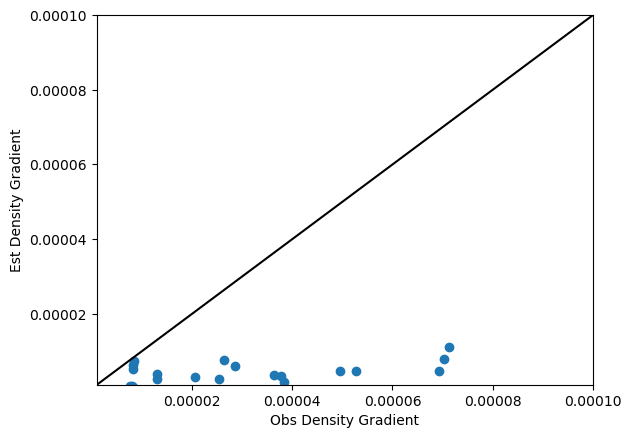

In [49]:
plt.scatter(coefs_nonadcp_front.rho_mag,rho_mag_est.isel(depth=0))
# plt.scatter(shear_est.isel(depth=0),shear_obs1.isel(depth=0))
plt.xlabel('Obs Density Gradient')
plt.ylabel('Est Density Gradient')
plt.xlim(1e-6,1e-4)
plt.ylim(1e-6,1e-4)
plt.plot([1e-6,1e-4],[1e-6,1e-4],color='k')

In [56]:
# calculate estimated shear from thermal wind equation 
uz_est = (1/f)*(g/rho0)*(coefs_nonadcp_front.rhoy)

In [65]:
# calculate estimated shear from thermal wind equation 
vz_est = -(1/f)*(g/rho0)*(coefs_nonadcp_front.rhox)

In [66]:
# shear_est = shear_est.expand_dims(dim={'depth':coefs_adcp_front.depth})    #broadcast to all depths?

In [67]:
uz_est

<xarray.DataArray (time: 20)>
array([0.00320491, 0.00315712, 0.00334061, 0.00342734, 0.00348292,
       0.00338044, 0.00334597, 0.00346833, 0.00489449, 0.01055349,
       0.01423223, 0.01857497, 0.02043517, 0.01982568, 0.01774222,
       0.01367013, 0.01019854, 0.00817394, 0.00684515, 0.00662943])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-28T19:15:12.558177792 ... 2020-0...
    longitude  (time) float64 -50.13 -50.13 -50.13 ... -50.09 -50.09 -50.09
    latitude   (time) float64 7.871 7.872 7.873 7.876 ... 7.885 7.885 7.884
    distance   (time) float64 ...

In [68]:
uz_obs = -coefs_adcp_front.u_prime.differentiate('depth')

In [69]:
vz_obs = -coefs_adcp_front.v_prime.differentiate('depth')

Text(0.5, 0, 'Observed Shear')

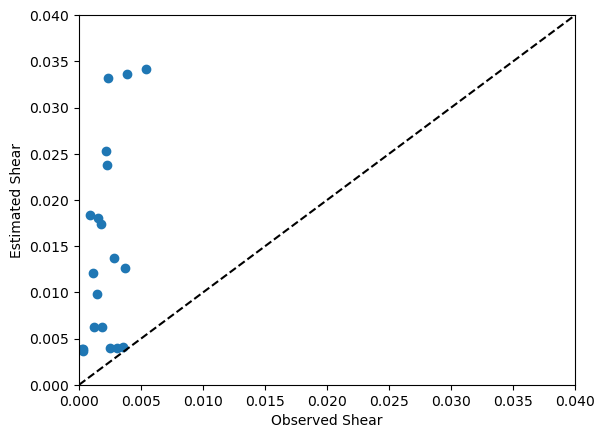

In [73]:
plt.scatter(np.sqrt(uz_obs.isel(depth=0)**2 + vz_obs.isel(depth=0)**2),np.sqrt(uz_est**2 + vz_est**2))
plt.ylim(0,0.04)
plt.xlim(0,0.04)
plt.plot([0,0.04],[0,0.04],color='k',linestyle='dashed')
plt.ylabel('Estimated Shear')
plt.xlabel('Observed Shear')

Text(0.5, 0, 'Observed Shear')

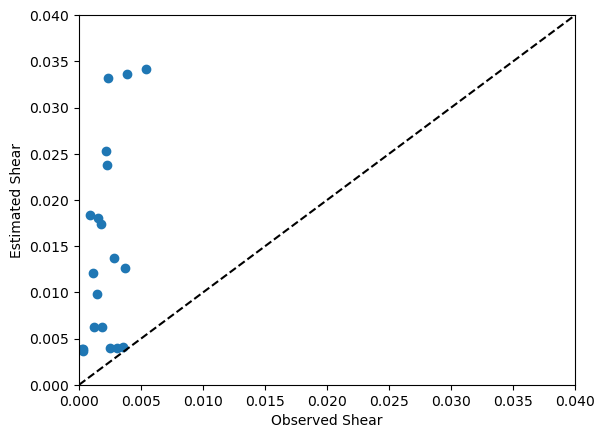

In [72]:
plt.scatter(shear_obs.isel(depth=0),shear_est)
plt.ylim(0,0.04)
plt.xlim(0,0.04)
plt.plot([0,0.04],[0,0.04],color='k',linestyle='dashed')
plt.ylabel('Estimated Shear')
plt.xlabel('Observed Shear')